In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

import seaborn as sns
import yfinance as yf

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

# ⏩ 1. Loading Data
For this project, we use daily data from Yahoo Finance (`yfinance`), covering the period from the beginning of 2015 up to June 1, 2015:

1. **S&P 500 Index** – Represents the U.S. stock market. This is the primary series we aim to classify into market regimes.  
2. **VIX Index** – Used as a supporting feature.

In [2]:
data = yf.download('^GSPC', interval='1D', start='2015-01-01', end='2025-06-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
vix = yf.download('^VIX', interval='1D', start='2015-01-01', end='2025-06-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
close = data['Close']
returns = (data['Close'] / data['Close'].shift()).dropna()
logs = np.log(returns)
volume = data['Volume']

In [5]:
vix_close = vix['Close']
vix_returns = (vix['Close'] / vix['Close'].shift()).dropna()
vix_logs = np.log(vix_returns)

# ⚙️ 2. Feature Engineering
In this step, we generate a wide range of rolling features from the input time series and its associated volume data.

1. **Feature Extraction**  
   We apply the `make_features()` function to compute various statistical and technical indicators, including:
   - Moving averages, standard deviation, skewness, and kurtosis over custom rolling windows
   - Distance from rolling peak and bottom (based on cumulative return)
   - Gaps between moving averages of different window sizes
   - RSI (Relative Strength Index) for windows 7, 14, and 21
   - MACD using standard spans (12, 26, 9)
   - ATR approximation using absolute return magnitudes over windows 7, 14, and 21

2. **Feature Visualization**  
   To gain an initial understanding of the behavior and sensitivity of the constructed features, we plot selected indicators such as:
   - Moving average vs. raw signal
   - RSI across multiple window sizes
   - MACD and its signal line
   - Volume and volatility proxies (e.g., ATR)

This step helps verify that the engineered features behave as expected and are suitable for downstream tasks such as clustering or anomaly detection.

## 2.1. Feature Extraction

In [6]:
def make_features(data, volume, windows, name):
    """
    Generates a wide set of rolling features for a time series and its volume.

    Parameters
    ----------
    data : pandas Series or DataFrame
        Main input series (e.g., returns or prices). If DataFrame, uses the first column.

    volume : pandas Series or DataFrame
        Corresponding volume series. If DataFrame, uses the first column.

    windows : list of int
        List of rolling window sizes for standard indicators.

    name : str
        Prefix used for naming the generated features.

    Returns
    -------
    pandas DataFrame
        DataFrame containing:
        - Moving averages, std, skew, kurtosis for each window
        - Distance from rolling cumulative peak and bottom
        - Gaps between moving averages of different windows
        - RSI for fixed windows: 7, 14, 21
        - MACD using standard spans (12, 26, 9)
        - ATR approximation for windows 7, 14, 21

    Notes
    -----
    - MACD is computed using fixed exponential windows (12-26-9).
    - RSI and ATR are computed for fixed windows [7, 14, 21], independently of `windows`.
    - Intermediate columns like rolling peaks and bottoms are dropped after use.
    - All features are aligned and cleaned with `.dropna()` at the end.
    """
    
    # Extract Series if input is DataFrame
    data_series = data.iloc[:, 0] if isinstance(data, pd.DataFrame) else pd.Series(data)
    volume_series = volume.iloc[:, 0] if isinstance(volume, pd.DataFrame) else pd.Series(volume)

    # Align both series
    data_series, volume_series = data_series.align(volume_series, join='inner')

    # Build initial DataFrame
    df = pd.DataFrame({name: data_series, 'volume': volume_series})

    # Moving Indicators
    for w in windows:
        df[f'{name}_ma_{w}'] = df[name].rolling(w).mean()
        df[f'{name}_mstd_{w}'] = df[name].rolling(w).std()
        df[f'{name}_mskew_{w}'] = df[name].rolling(w).skew()
        df[f'{name}_mkurt_{w}'] = df[name].rolling(w).kurt()
        df[f'{name}_peak_{w}'] = df[name].cumsum().rolling(w).max()
        df[f'{name}_bottom_{w}'] = df[name].cumsum().rolling(w).min()

    # Distance from peak/bottom
    for w in windows:
        df[f'{name}_from_peak_{w}'] = df[name].cumsum() - df[f'{name}_peak_{w}']
        df[f'{name}_from_bottom_{w}'] = df[name].cumsum() - df[f'{name}_bottom_{w}']

    # Drop raw peak and bottom columns
    df.drop(columns=[f'{name}_peak_{w}' for w in windows] + 
                    [f'{name}_bottom_{w}' for w in windows], inplace=True)

    # MA gaps
    for comb in combinations(windows, 2):
        df[f'{name}_ma_gap_{comb[0]}_{comb[1]}'] = df[f'{name}_ma_{comb[0]}'] - df[f'{name}_ma_{comb[1]}']

    # RSI (Relative Strength Index) for multiple windows
    for w in [7, 14, 21]:
        delta = df[name].diff()
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        roll_up = up.rolling(w).mean()
        roll_down = down.rolling(w).mean()
        rs = roll_up / roll_down
        df[f'{name}_RSI_{w}'] = 100 - (100 / (1 + rs))

    # MACD (12-26 EMA with 9 EMA signal)
    ema_12 = df[name].ewm(span=12, adjust=False).mean()
    ema_26 = df[name].ewm(span=26, adjust=False).mean()
    df[f'{name}_MACD'] = ema_12 - ema_26
    df[f'{name}_MACD_signal'] = df[f'{name}_MACD'].ewm(span=9, adjust=False).mean()
    df[f'{name}_MACD_hist'] = df[f'{name}_MACD'] - df[f'{name}_MACD_signal']
    # ATR approximation using log return magnitudes (since no OHLC data)
    
    for w in [7, 14, 21]:
        df[f'{name}_ATR_{w}'] = df[name].abs().rolling(w).mean()

    return df.dropna()

In [7]:
windows = [10,20,50,100,200]
features = make_features(logs, volume[1:], windows, name='^GSPC')

In [8]:
start_from = len(logs) - len(vix_logs)
features['vix'] = vix_logs.iloc[start_from:] # Add the VIX index to the features dataframe

## 📈 2.2. Features Visualizing

### 2.2.1. Visualizing Logarithmic Distance from Peak and Bottom

In this section, we visualize the **logarithmic cumulative distance** from the local peak and bottom of the S&P 500 index, calculated over multiple rolling windows.

The cumulative log returns are used to track the evolution of the log price over time.  
For each rolling window size, we compute the local maximum and minimum of the cumulative log returns, and plot the difference from them:

- **Distance from peak**:  
  This value is always ≤ 0, since a new peak resets the distance to zero.  
  It measures how far the log price has fallen from its most recent high.

- **Distance from bottom**:  
  This value is always ≥ 0, since a new bottom resets the distance to zero.  
  It measures how far the log price has risen from its most recent low.

These plots allow us to capture the asset's relative position within its recent historical range, in log scale, across different time horizons.

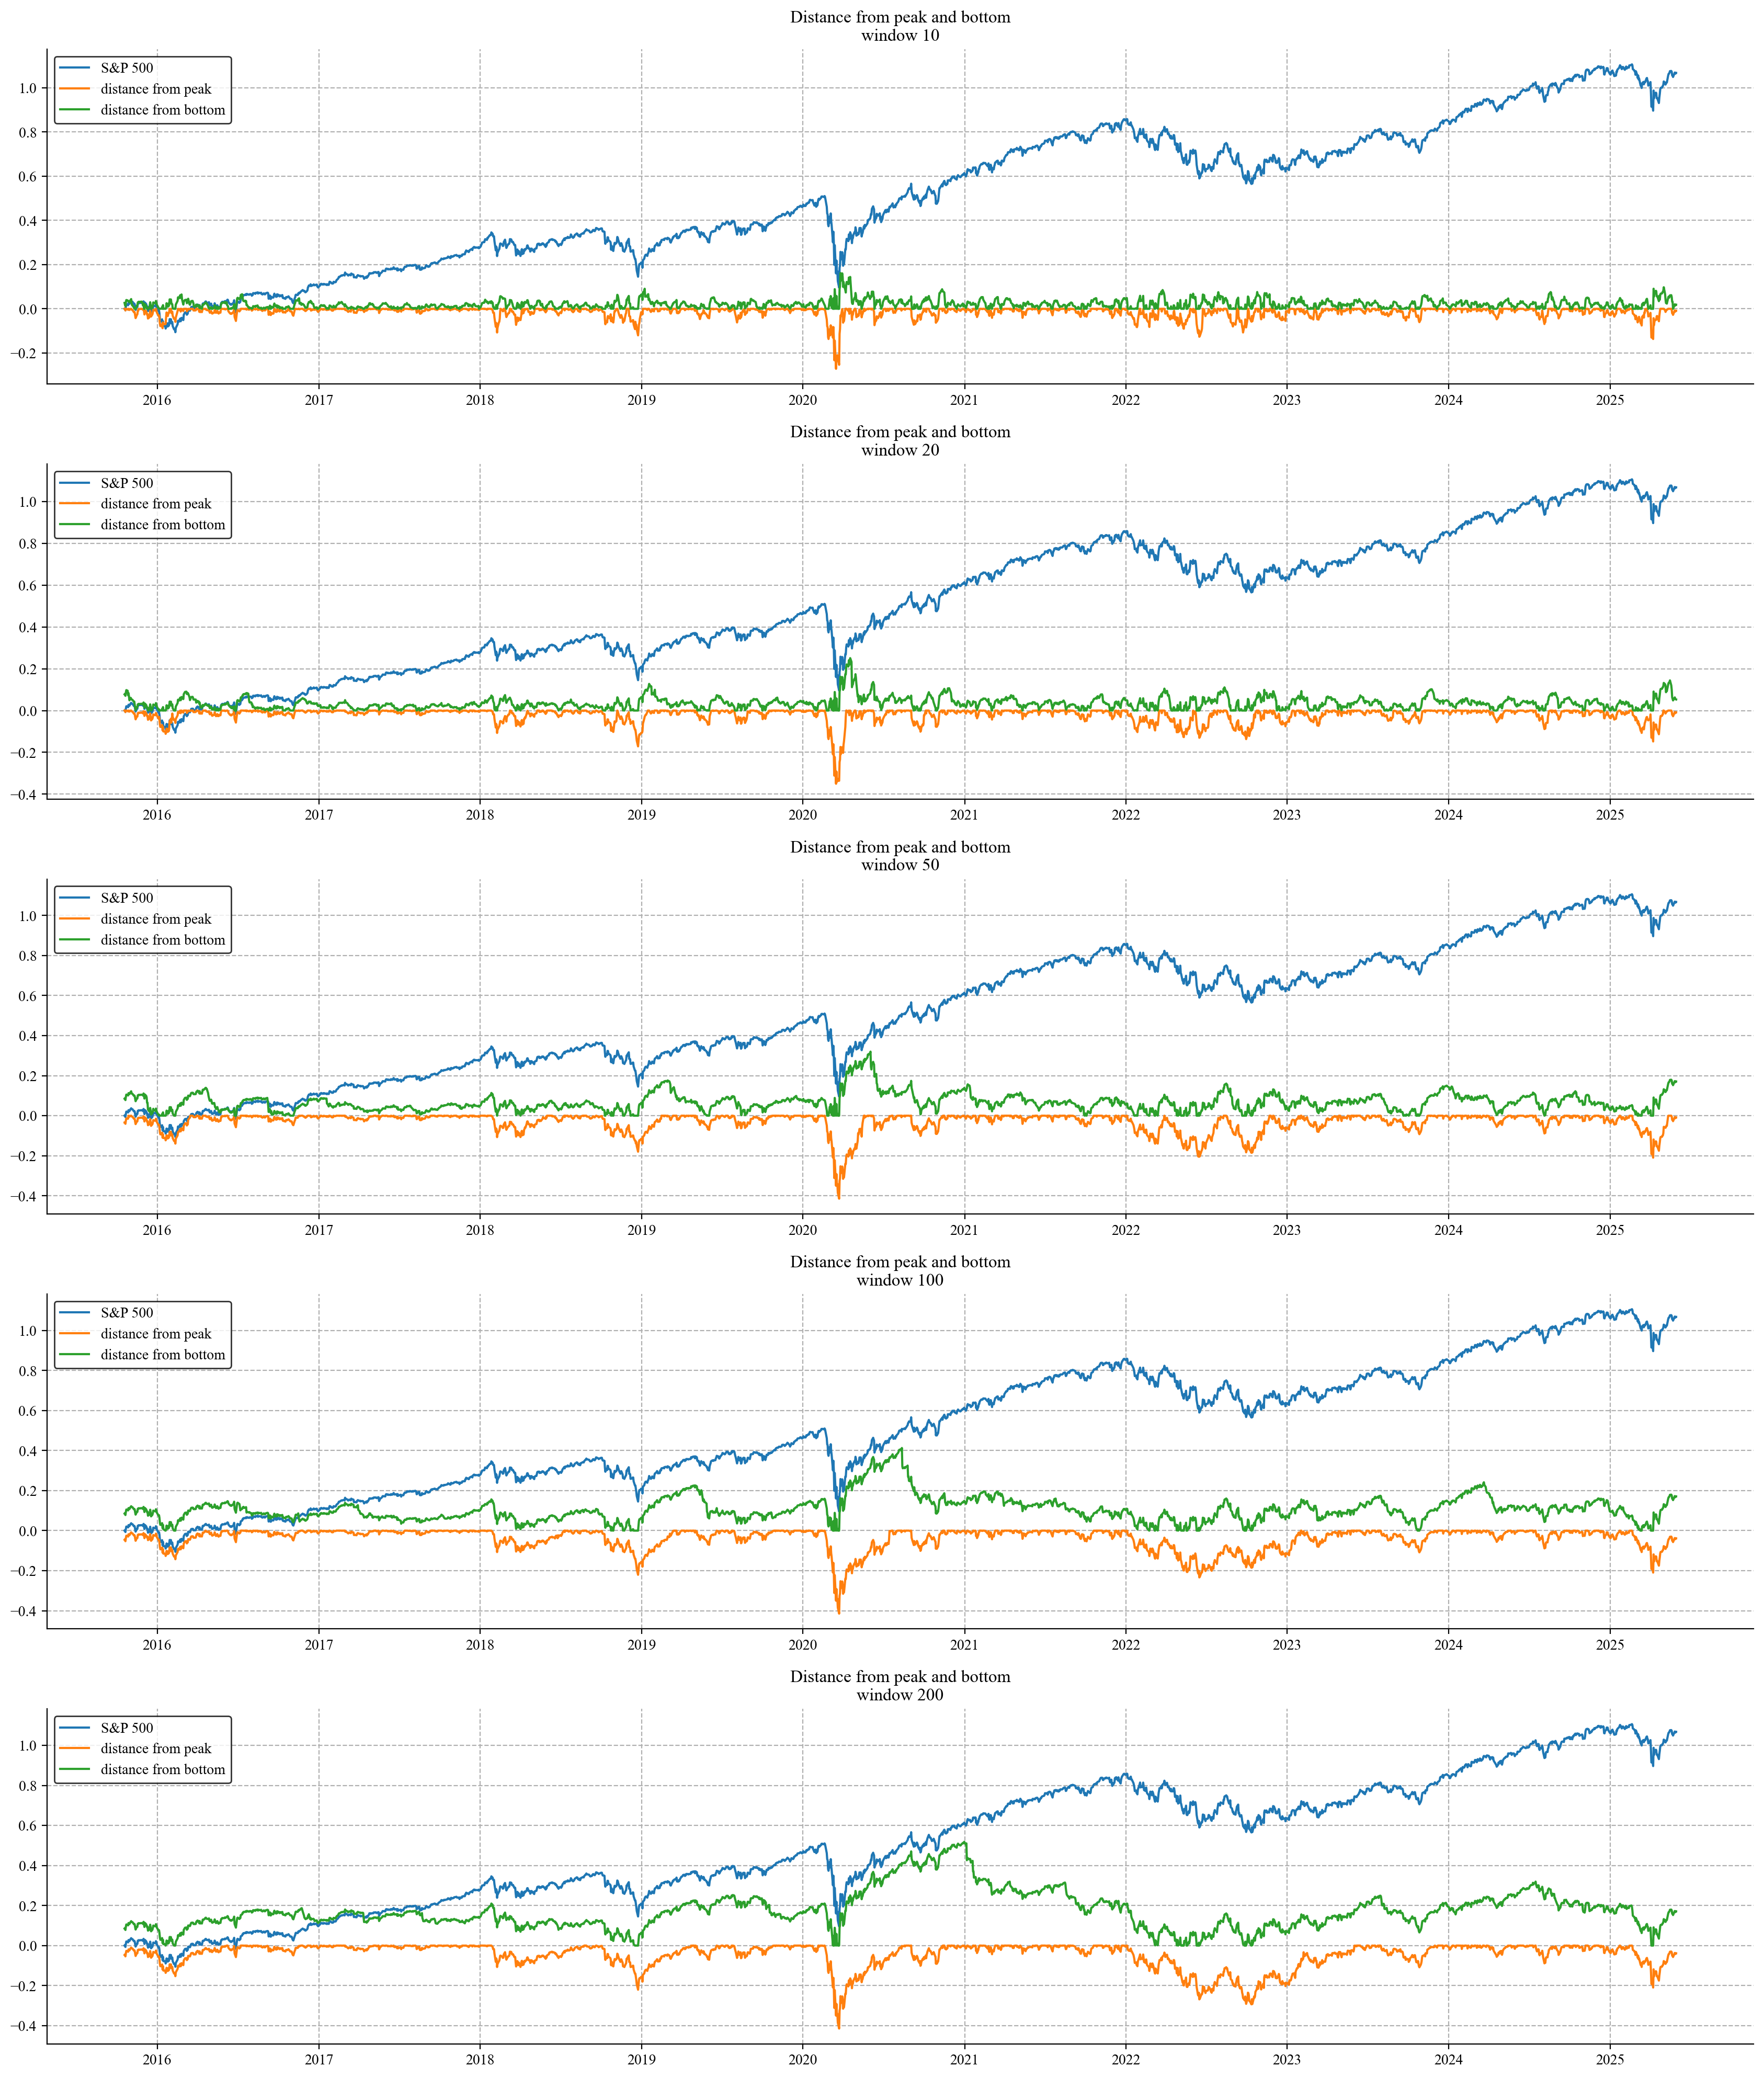

In [9]:
fig, ax = plt.subplots(len(windows), 1, figsize=(17,20), dpi=200)
for i, w in enumerate(windows):
    ax[i].plot(features['^GSPC'].cumsum(), label='S&P 500')
    ax[i].plot(features[f'^GSPC_from_peak_{w}'], label='distance from peak')
    ax[i].plot(features[f'^GSPC_from_bottom_{w}'], label='distance from bottom')
    ax[i].set_title(f'Distance from peak and bottom\nwindow {w}')
    ax[i].grid(ls='--')
    ax[i].legend(edgecolor='k')
sns.despine()
plt.tight_layout(pad=1.2)
plt.show()

### 2.2.2. Visualizing Gaps Between Moving Averages
This section illustrates the **gaps between moving averages** of different window sizes.  
These gaps capture differences in trend behavior across short- and long-term periods, and can be interpreted as a proxy for momentum or trend acceleration.

For each pair of rolling windows (e.g., 7 vs. 21), we calculate the difference between their moving averages:
```python
df['ma_gap_7_21'] = ma_7 - ma_21
```

The resulting plots show how these gaps evolve over time.
Positive gaps typically indicate short-term strength relative to the longer trend, while negative gaps may signal weakening momentum or a reversal.  
By visualizing all such gaps, we gain insight into how market dynamics shift across different time horizons.

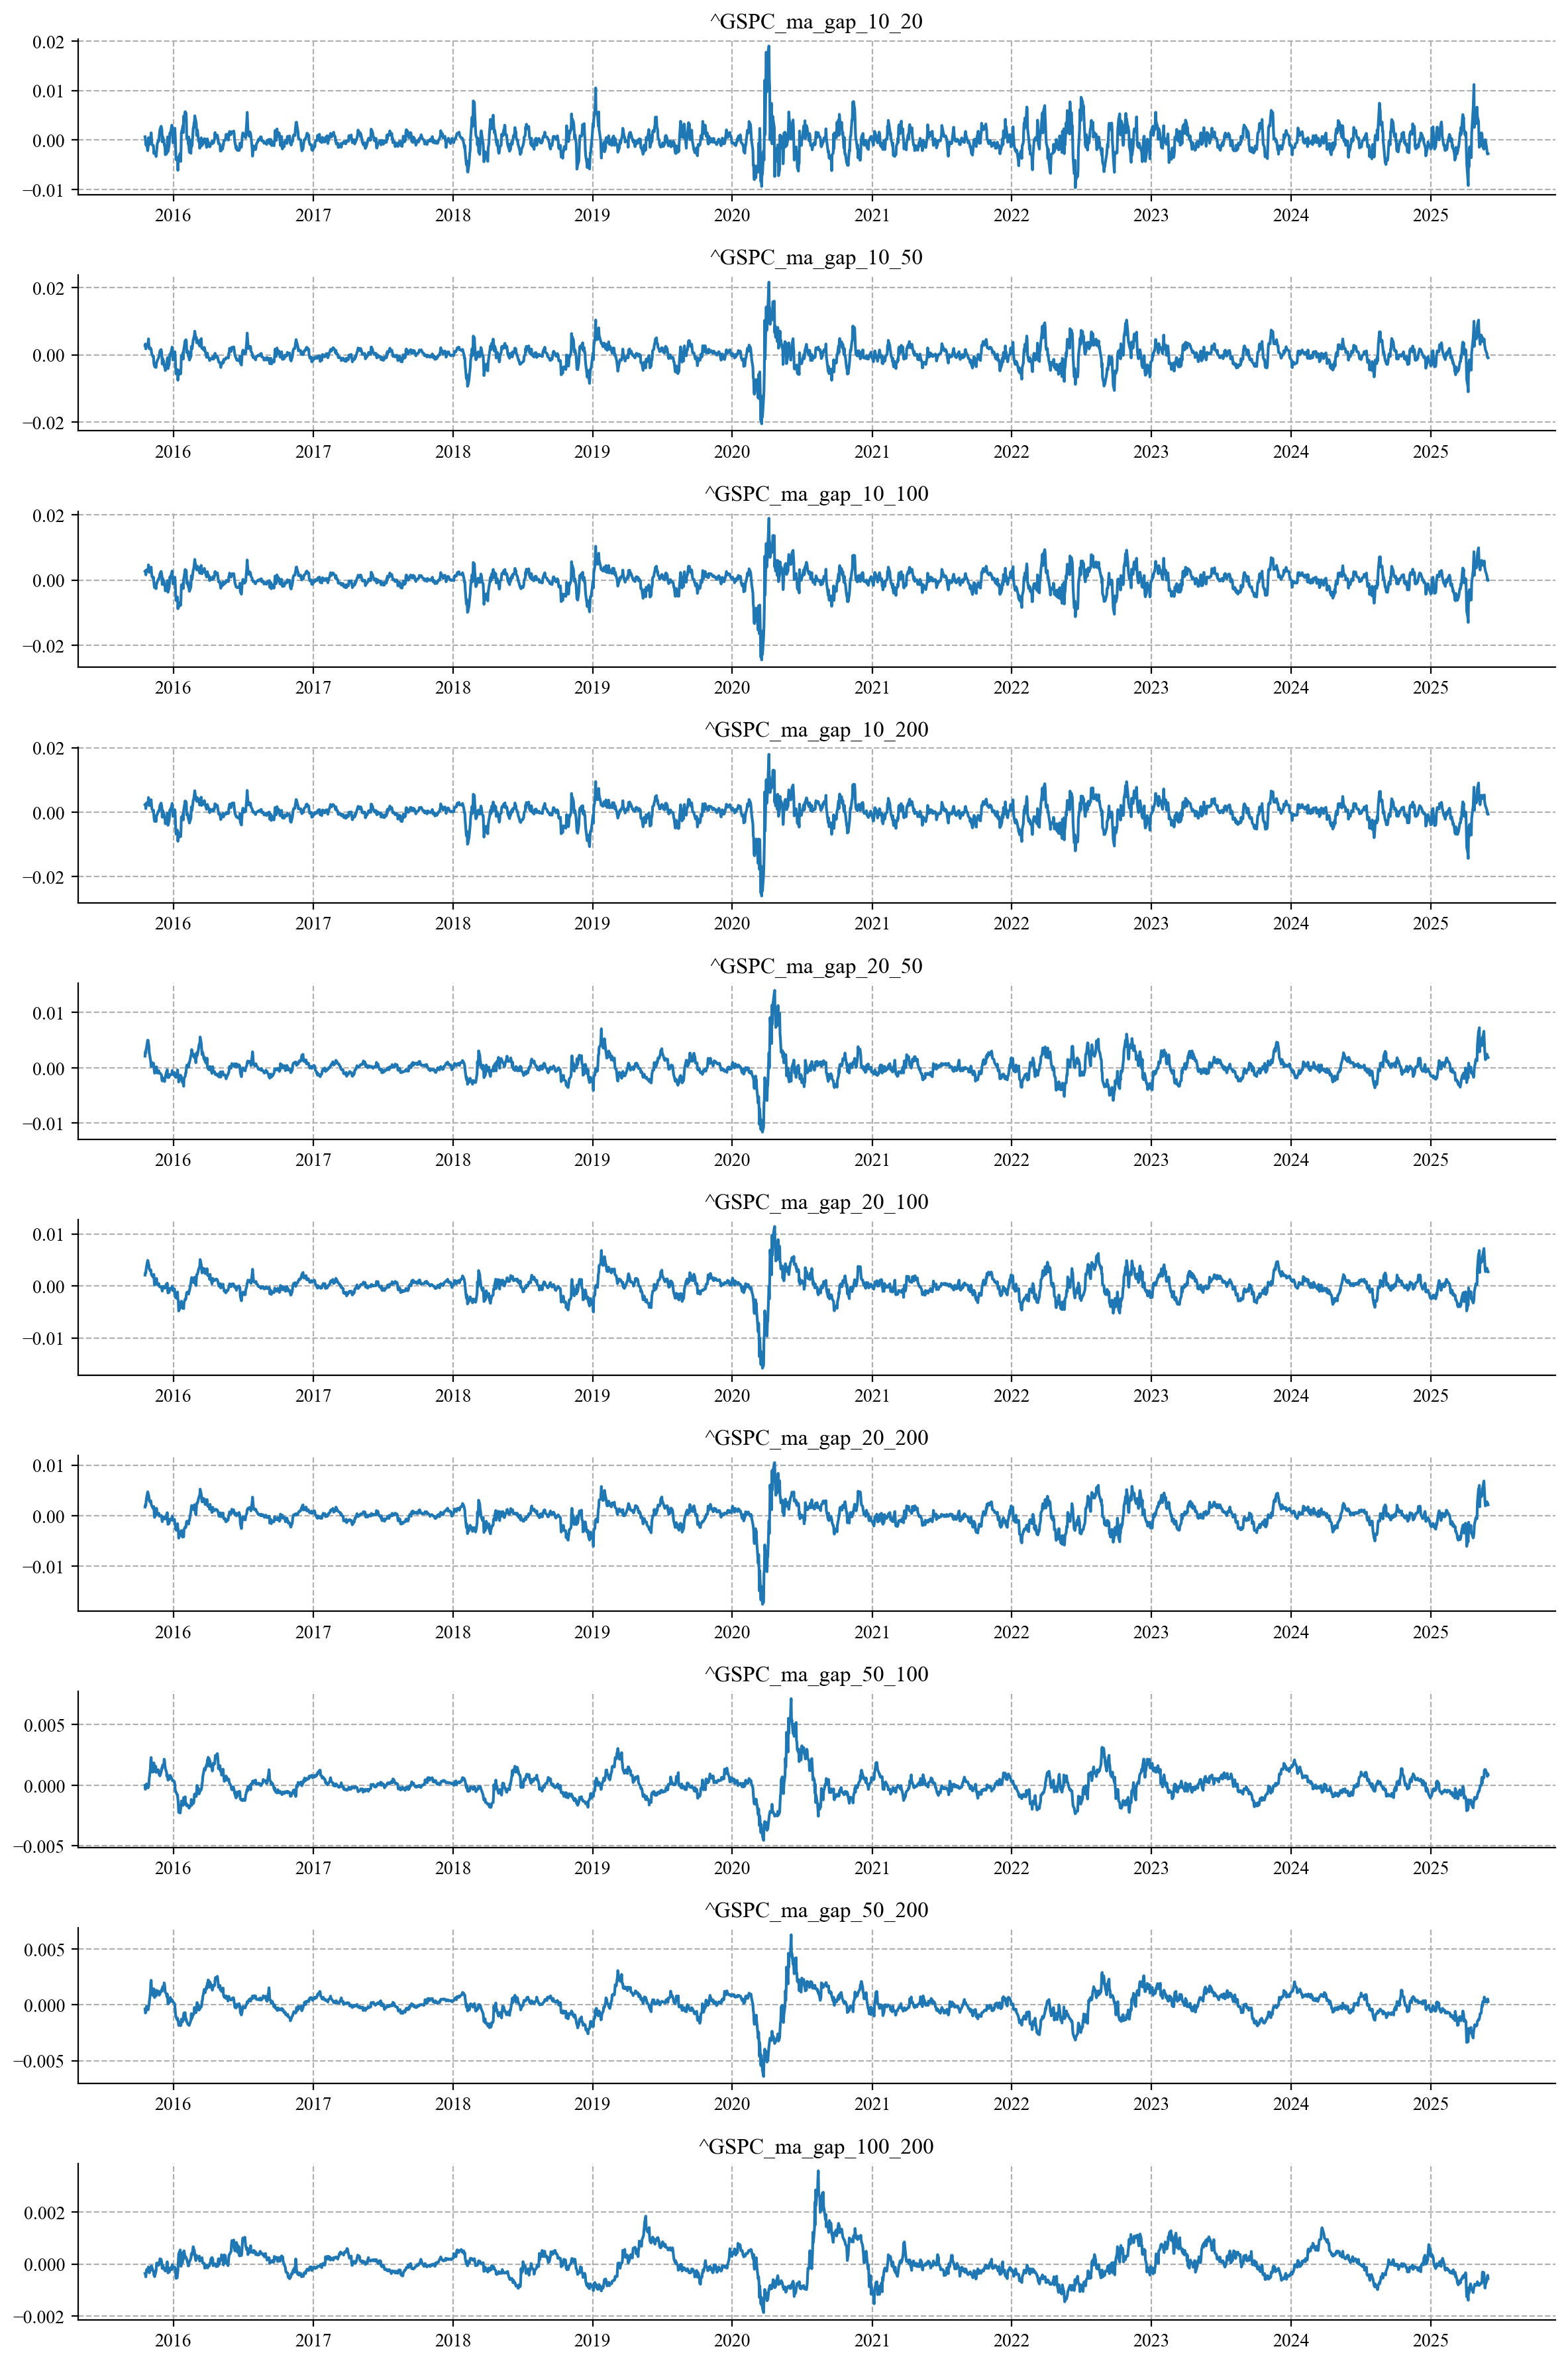

In [10]:
gaps_counter = []
for col in features.columns:
    if 'gap' in col:
        gaps_counter.append(col)

fig, ax = plt.subplots(len(gaps_counter), 1, figsize=(12,18), dpi=200)
for i, col in enumerate(gaps_counter):
    if 'gap' in col:
        ax[i].plot(features[col], label=col)
        ax[i].grid(ls='--')
        ax[i].set_title(col)

sns.despine()
plt.tight_layout(pad=1.3)
plt.show()

### 2.2.3. Correlation Analysis

In this section, we compute the Pearson correlation between all engineered features and the cumulative log return of the S&P 500 index (`^GSPC`).

We visualize the results using a heatmap to highlight which features are most strongly correlated—positively or negatively—with the main signal.

This helps identify features that move closely with the index and may carry predictive value or serve as key drivers in further analysis.

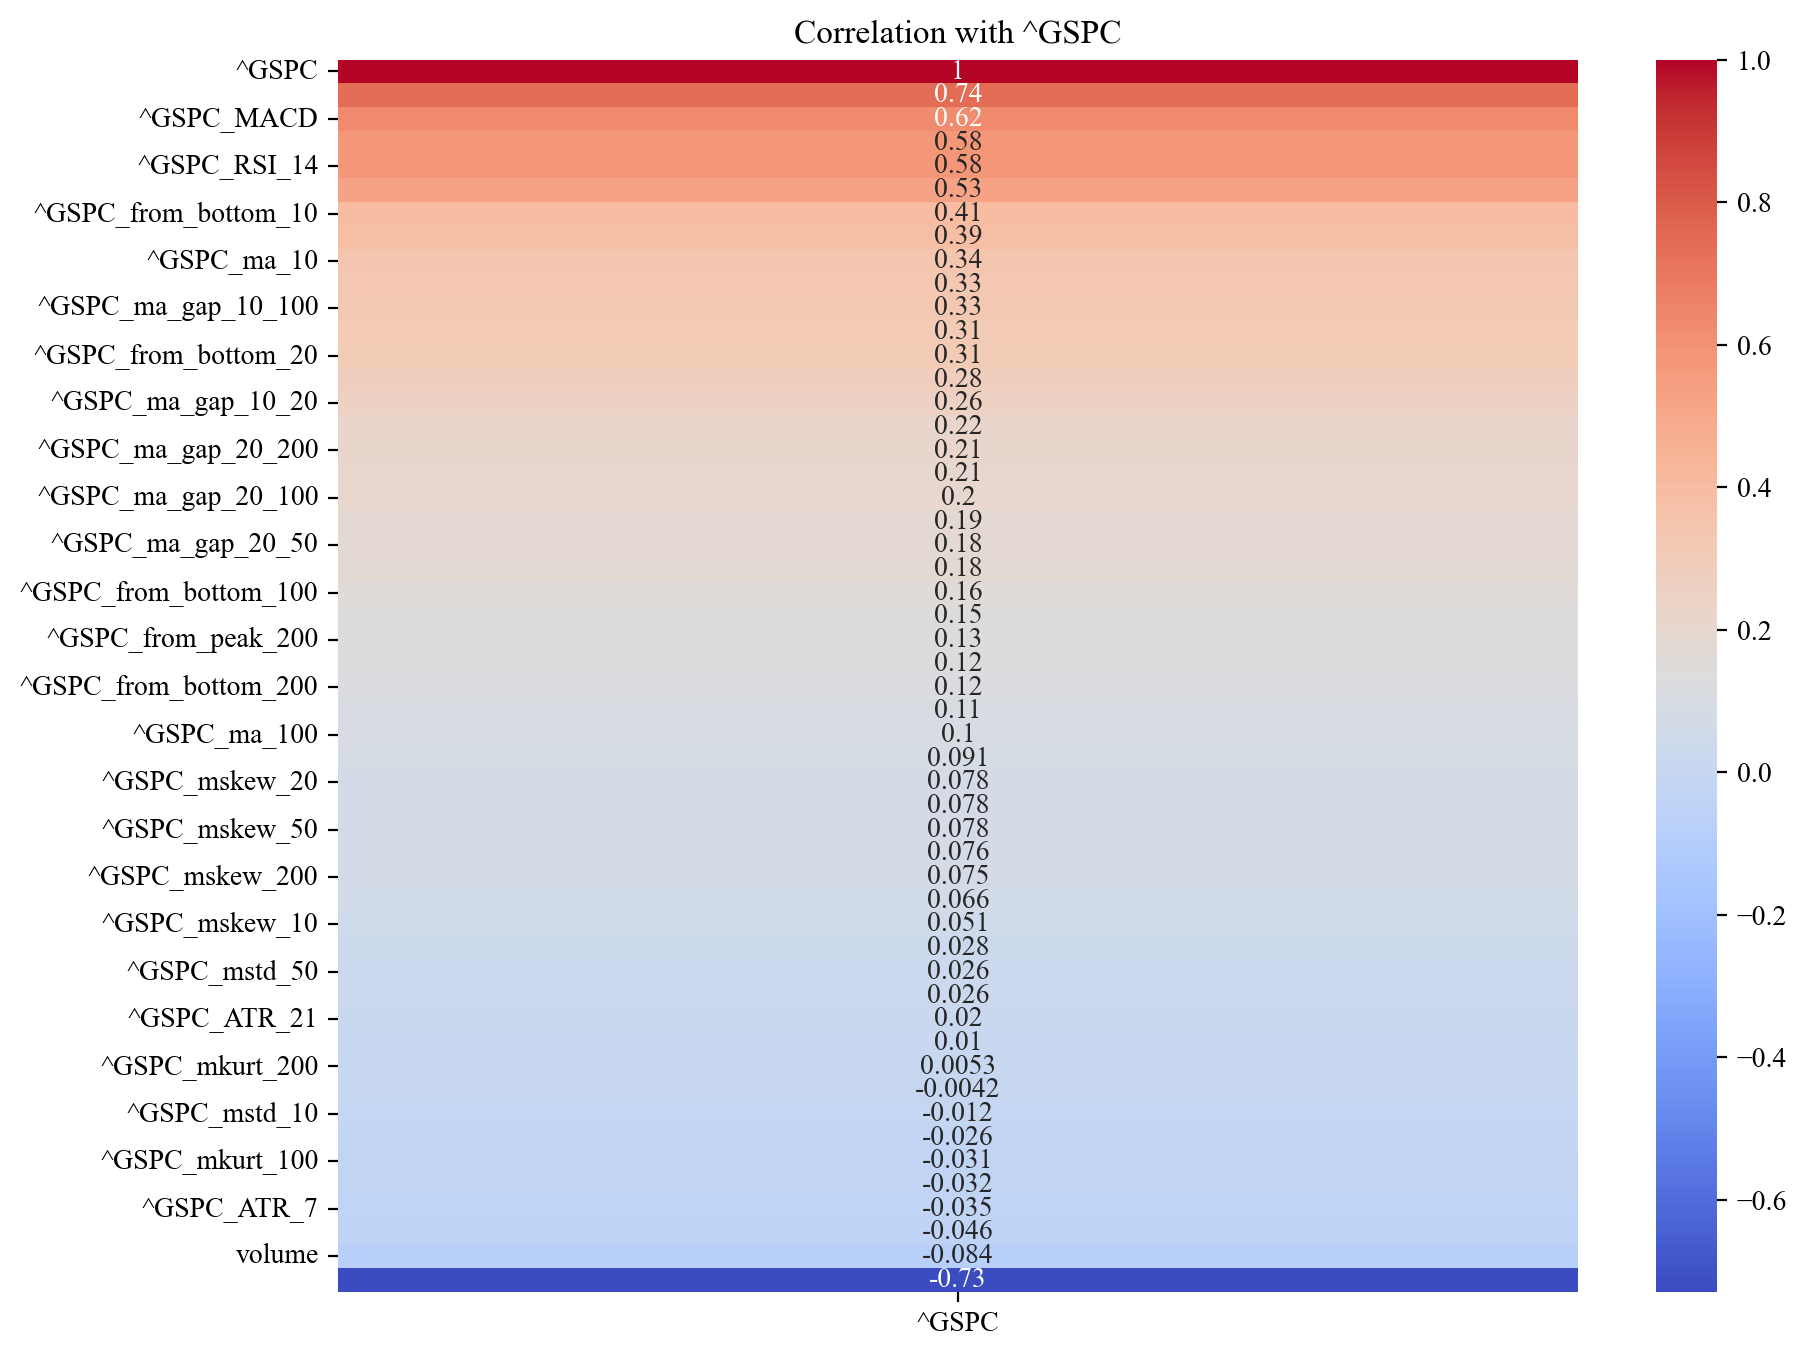

In [11]:
corr = features.corr()
plt.figure(figsize=(10,8), dpi=200)
sns.heatmap(corr[['^GSPC']].sort_values(by='^GSPC', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with ^GSPC")
plt.show()

# 📐 3. Feature Distribution and Normalization
In this section, we examine the statistical properties of the engineered features to determine an appropriate normalization method.

Algorithms such as **KMeans** and **PCA**, which we will use later in the project, are highly sensitive to differences in feature scale.  
Improper scaling can lead to biased clustering or distorted component directions.

To address this, we:

- Use the `describe()` function to get a general overview of each feature's scale, spread, and central tendency.
- Apply the **Shapiro-Wilk normality test** to evaluate whether the features follow a normal distribution.

These insights guide us in choosing the most suitable normalization technique (e.g., z-score standardization, Min-Max scaling, or rank transformation) for downstream tasks.


In [12]:
features.describe()

^GSPC        volume  ^GSPC_ma_10  ^GSPC_mstd_10  ^GSPC_mskew_10  \
count  2418.000000  2.418000e+03  2418.000000    2418.000000     2418.000000   
mean      0.000441  4.082841e+09     0.000446       0.009340       -0.028606   
std       0.011640  1.000237e+09     0.003308       0.007145        0.768878   
min      -0.127652  0.000000e+00    -0.026639       0.001459       -2.597509   
25%      -0.003766  3.476260e+09    -0.000823       0.005092       -0.506497   
50%       0.000703  3.882265e+09     0.000818       0.007681       -0.012838   
75%       0.005818  4.461630e+09     0.002309       0.011491        0.458791   
max       0.090895  9.976520e+09     0.017439       0.075383        2.789096   

       ^GSPC_mkurt_10  ^GSPC_ma_20  ^GSPC_mstd_20  ^GSPC_mskew_20  \
count     2418.000000  2418.000000    2418.000000     2418.000000   
mean         0.277370     0.000449       0.009598       -0.148746   
std          1.595871     0.002326       0.006689        0.698858   
min         -2.207698    -0.018513       0.002069       -3.014435   
25%         -0.880428    -0.000495       0.005603       -0.490751   
50%         -0.143926     0.000799       0.007934       -0.122402   
75%          1.028132     0.001734       0.011997        0.259850   
max          8.334433     0.010141       0.061669        2.447373   

       ^GSPC_mkurt_20  ...  ^GSPC_RSI_7  ^GSPC_RSI_14  ^GSPC_RSI_21  \
count     2418.000000  ...  2418.000000   2418.000000   2418.000000   
mean         0.608353  ...    49.255877     49.698569     49.853005   
std          1.809047  ...     9.759438      4.868572      3.219893   
min         -1.596056  ...     7.026712     25.129189     33.454477   
25%         -0.578590  ...    43.454878     46.645924     47.964490   
50%          0.089550  ...    49.744726     49.970163     49.959189   
75%          1.104832  ...    55.679773     52.888070     51.902080   
max         11.415222  ...    82.354117     67.107605     62.379136   

        ^GSPC_MACD  ^GSPC_MACD_signal  ^GSPC_MACD_hist  ^GSPC_ATR_7  \
count  2418.000000        2418.000000      2418.000000  2418.000000   
mean      0.000004           0.000006        -0.000002     0.007482   
std       0.001392           0.000914         0.000940     0.006114   
min      -0.011532          -0.005584        -0.006484     0.001015   
25%      -0.000576          -0.000392        -0.000441     0.003933   
50%       0.000045           0.000030        -0.000022     0.005985   
75%       0.000665           0.000427         0.000404     0.009364   
max       0.009438           0.005579         0.008922     0.078851   

       ^GSPC_ATR_14  ^GSPC_ATR_21          vix  
count   2418.000000   2418.000000  2418.000000  
mean       0.007483      0.007484     0.000087  
std        0.005621      0.005290     0.080811  
min        0.001350      0.001811    -0.442449  
25%        0.004216      0.004394    -0.044069  
50%        0.006081      0.006121    -0.007091  
75%        0.009322      0.009406     0.034753  
max        0.060402      0.051426     0.768245  

[8 rows x 52 columns]

In [13]:
for col in features.columns:
    results = st.shapiro(features[col])
    pvalue = results[1]
    if pvalue<=0.05:
        print(f"❌ Feature {col} ISN'T normal")
    else:
        print(f'✅ Feature {col} IS NORMAL')

❌ Feature ^GSPC ISN'T normal
❌ Feature volume ISN'T normal
❌ Feature ^GSPC_ma_10 ISN'T normal
❌ Feature ^GSPC_mstd_10 ISN'T normal
❌ Feature ^GSPC_mskew_10 ISN'T normal
❌ Feature ^GSPC_mkurt_10 ISN'T normal
❌ Feature ^GSPC_ma_20 ISN'T normal
❌ Feature ^GSPC_mstd_20 ISN'T normal
❌ Feature ^GSPC_mskew_20 ISN'T normal
❌ Feature ^GSPC_mkurt_20 ISN'T normal
❌ Feature ^GSPC_ma_50 ISN'T normal
❌ Feature ^GSPC_mstd_50 ISN'T normal
❌ Feature ^GSPC_mskew_50 ISN'T normal
❌ Feature ^GSPC_mkurt_50 ISN'T normal
❌ Feature ^GSPC_ma_100 ISN'T normal
❌ Feature ^GSPC_mstd_100 ISN'T normal
❌ Feature ^GSPC_mskew_100 ISN'T normal
❌ Feature ^GSPC_mkurt_100 ISN'T normal
❌ Feature ^GSPC_ma_200 ISN'T normal
❌ Feature ^GSPC_mstd_200 ISN'T normal
❌ Feature ^GSPC_mskew_200 ISN'T normal
❌ Feature ^GSPC_mkurt_200 ISN'T normal
❌ Feature ^GSPC_from_peak_10 ISN'T normal
❌ Feature ^GSPC_from_bottom_10 ISN'T normal
❌ Feature ^GSPC_from_peak_20 ISN'T normal
❌ Feature ^GSPC_from_bottom_20 ISN'T normal
❌ Feature ^GSPC_from_

🔍 As shown, there are significant scale differences across the features, and none of them follow a normal distribution.

In this case, using a **RobustScaler** is the most natural choice, due to its resilience to non-Gaussian distributions and extreme values—both of which are common in financial data.


In [14]:
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)
scaled_features_df = pd.DataFrame(columns=features.columns,
                                 data= scaled_features,
                                 index=features.index)
scaled_features_df.head()

^GSPC    volume  ^GSPC_ma_10  ^GSPC_mstd_10  ^GSPC_mskew_10  \
Date                                                                         
2015-10-19 -0.045105 -0.603778     0.479236      -0.145567        0.501030   
2015-10-20 -0.221719 -0.558942     0.548600      -0.173526        0.491798   
2015-10-21 -0.682955 -0.258253     0.106545      -0.145975        0.912819   
2015-10-22  1.647388  0.556730     0.352733       0.055112        1.050512   
2015-10-23  1.071317  0.229553     0.679825       0.128540        0.591039   

            ^GSPC_mkurt_10  ^GSPC_ma_20  ^GSPC_mstd_20  ^GSPC_mskew_20  \
Date                                                                     
2015-10-19       -0.135648     0.389611       0.421520       -0.534903   
2015-10-20       -0.021726     0.635732       0.344537       -0.676425   
2015-10-21        0.306972     0.550684       0.363109       -0.597679   
2015-10-22        0.101856     0.996133       0.426235       -0.724654   
2015-10-23       -0.530567     1.252640       0.443340       -0.899915   

            ^GSPC_mkurt_20  ...  ^GSPC_RSI_7  ^GSPC_RSI_14  ^GSPC_RSI_21  \
Date                        ...                                            
2015-10-19        0.713629  ...    -0.638346     -0.051185      0.876915   
2015-10-20        1.240096  ...    -0.168238     -1.332989     -0.329088   
2015-10-21        1.067940  ...    -0.557807     -0.568670      0.404559   
2015-10-22        0.889082  ...     1.500607      0.157738      1.065865   
2015-10-23        0.890090  ...     0.966271     -0.469419      0.811510   

            ^GSPC_MACD  ^GSPC_MACD_signal  ^GSPC_MACD_hist  ^GSPC_ATR_7  \
Date                                                                      
2015-10-19    0.732329           1.422112        -0.259191    -0.229998   
2015-10-20    0.402464           1.263351        -0.590174    -0.211658   
2015-10-21   -0.144980           0.970387        -1.110873    -0.091509   
2015-10-22    0.862263           1.041357         0.301168     0.162112   
2015-10-23    1.286461           1.226727         0.745031     0.326313   

            ^GSPC_ATR_14  ^GSPC_ATR_21       vix  
Date                                              
2015-10-19      0.302122      0.268634  0.030816  
2015-10-20      0.057656      0.238861  0.725882  
2015-10-21      0.111806      0.176597  0.833010  
2015-10-22      0.143663      0.313811 -1.746003  
2015-10-23      0.043566      0.386040  0.098740  

[5 rows x 52 columns]

# 🧮 4. K-Means
At this stage, we train a **KMeans** algorithm to classify the data into clusters.

First, we use a training loop to apply the **elbow method**, which helps determine the optimal number of clusters.  
Then, we perform the final training of the algorithm using the selected number of clusters and analyze the resulting cluster behavior.

## 4.1. Elbow Loop

In [15]:
def make_elbow(data):
    inertia = {}
    for i in range(1, 10):
        kmeans = KMeans(n_clusters=i, 
                        n_init=100,
                       max_iter=10000, 
                       random_state=999)
        kmeans.fit(data)
        inertia[i] = kmeans.inertia_
    return inertia

In [16]:
elbow = make_elbow(scaled_features_df)

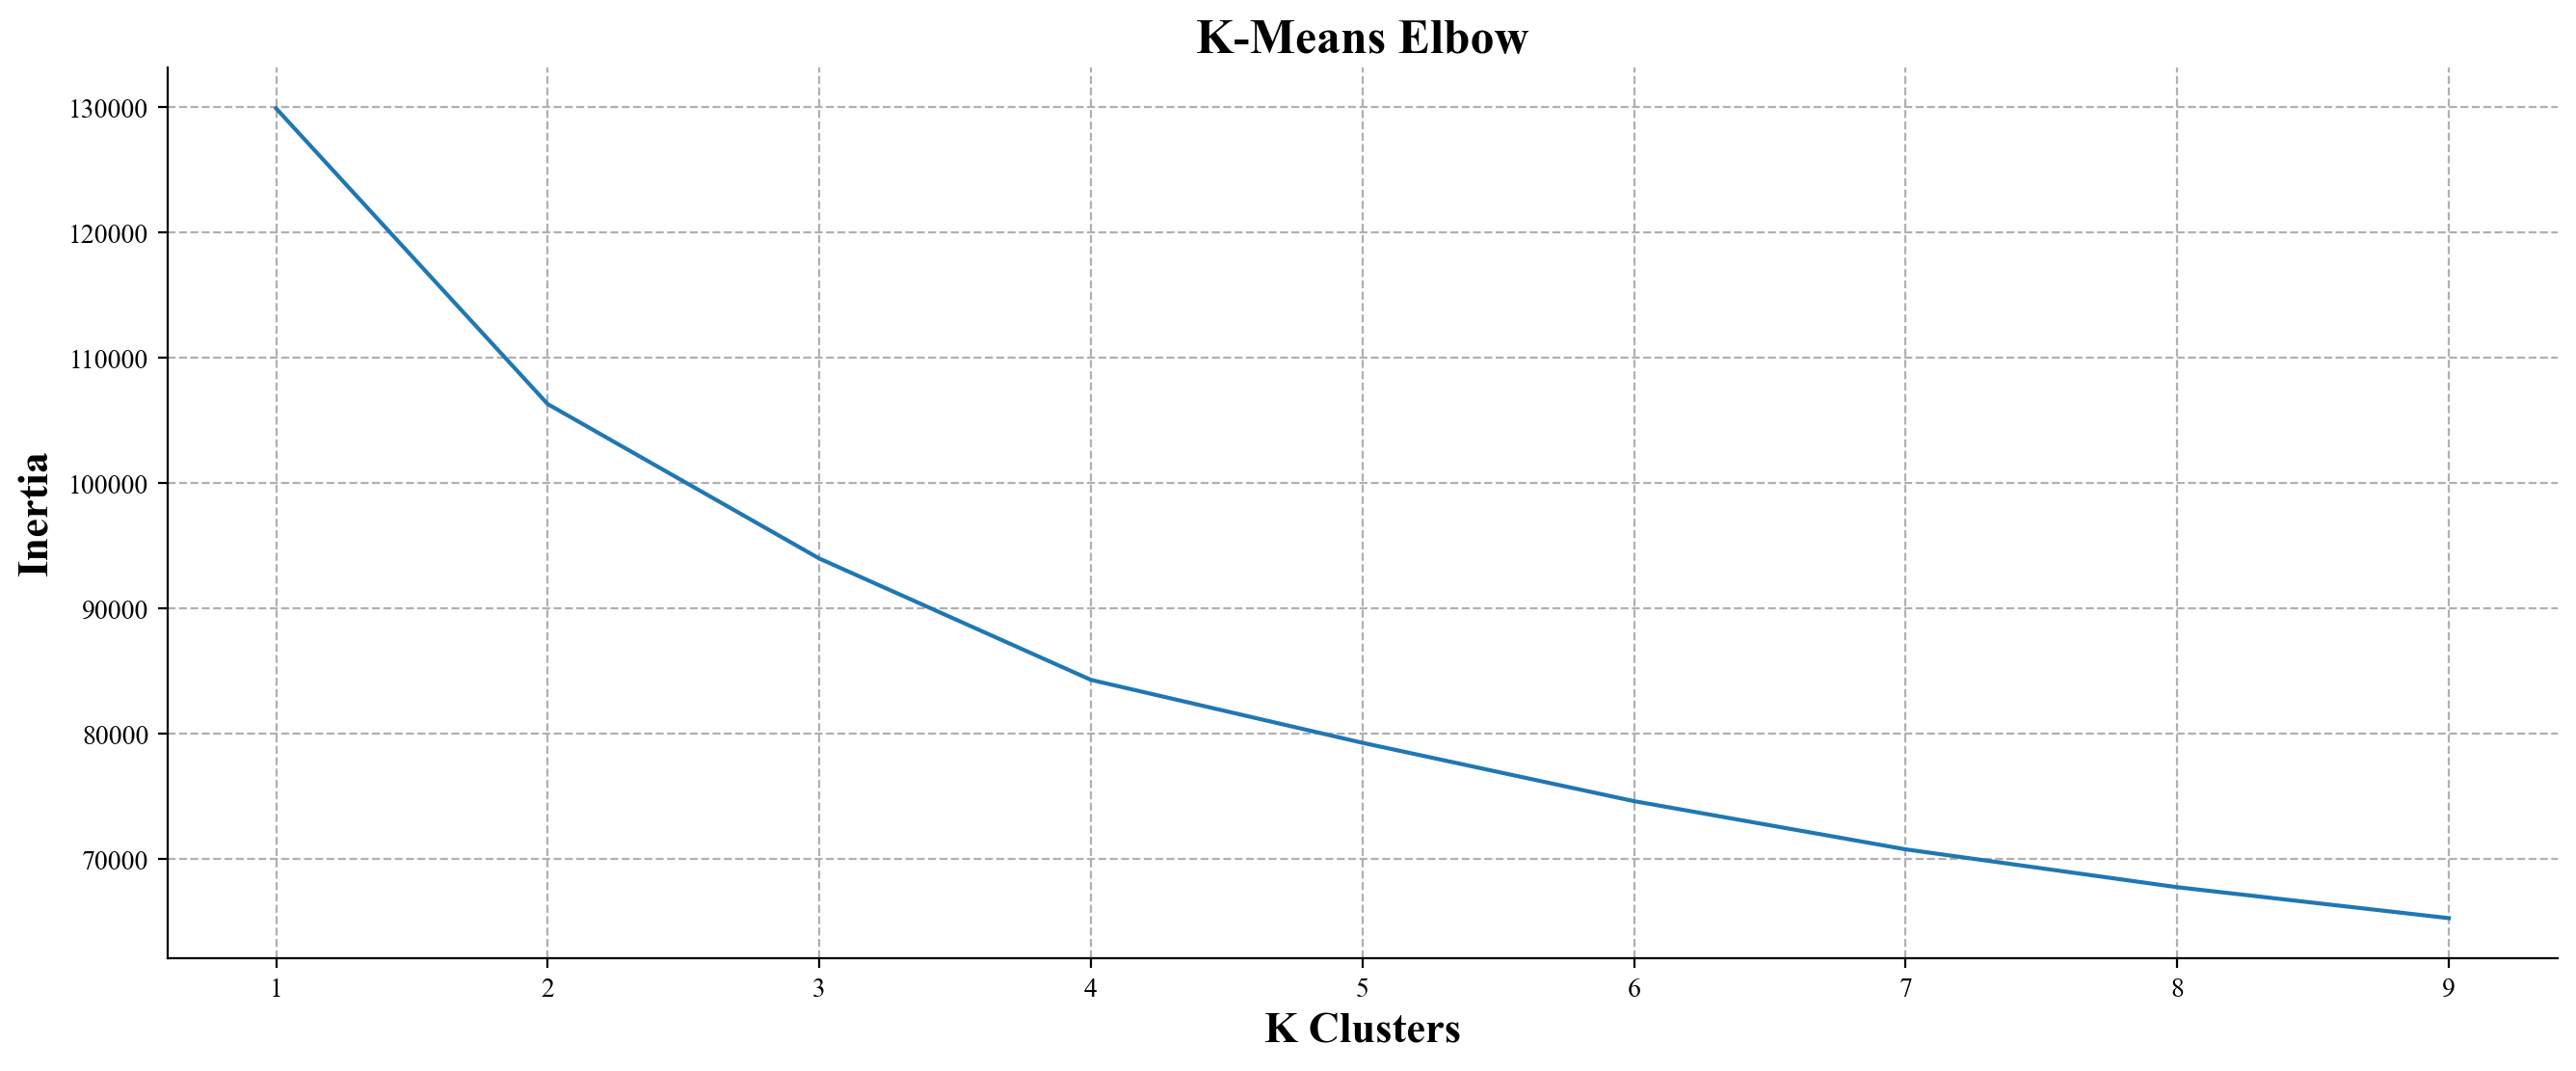

In [17]:
plt.figure(figsize=(16,6), dpi=200)
plt.plot(elbow.keys(), elbow.values())
plt.title('K-Means Elbow', size=18, weight='bold')
plt.xlabel('K Clusters', size=16, weight='bold')
plt.ylabel('Inertia', size=16, weight='bold')
plt.grid(ls='--')
sns.despine()
plt.show()

🔍 According to the elbow plot, the most significant reduction in inertia occurs up to the third cluster.  
Therefore, we train the final model to classify the data into **three clusters**.

## 4.2. Final Fit

In [18]:
kmeans = KMeans(n_clusters=3,
               n_init=10,
               max_iter=1000,
               random_state=999)

In [19]:
kmeans.fit(scaled_features_df)

KMeans(max_iter=1000, n_clusters=3, n_init=10, random_state=999)

In [20]:
kmeans_pred = kmeans.predict(scaled_features_df)

# 🎲 5. Groups Analysis
After clustering, we construct a final DataFrame that includes both the feature values and the cluster assignments.  
We can then split the DataFrame by cluster and analyze the statistical behavior of each group individually.

In [21]:
regimes_df = features.copy()
regimes_df['cluster'] = kmeans_pred

In [22]:
groups = regimes_df.groupby('cluster')

## 5.1. Statistical Analysis
We begin by examining the basic statistical characteristics of each cluster:  
**mean**, **variance**, **skewness**, and **kurtosis**.  
These metrics provide a foundation for understanding the clustering decisions made by the algorithm.

In [23]:
groups_performance = pd.DataFrame(
                                data = {'avg return': [group['^GSPC'].mean() for _, group in groups],
                                'std': [group['^GSPC'].std() for _, group in groups],
                                'skew': [st.skew(group['^GSPC']) for _, group in groups],
                                'kurtosis': [st.kurtosis(group['^GSPC']) for _, group in groups]
                                })
groups_performance

avg return       std      skew  kurtosis
0    0.005777  0.013885  1.234646  5.777235
1   -0.007450  0.021043 -0.220927  5.928638
2    0.001087  0.006808 -0.205007  1.337258

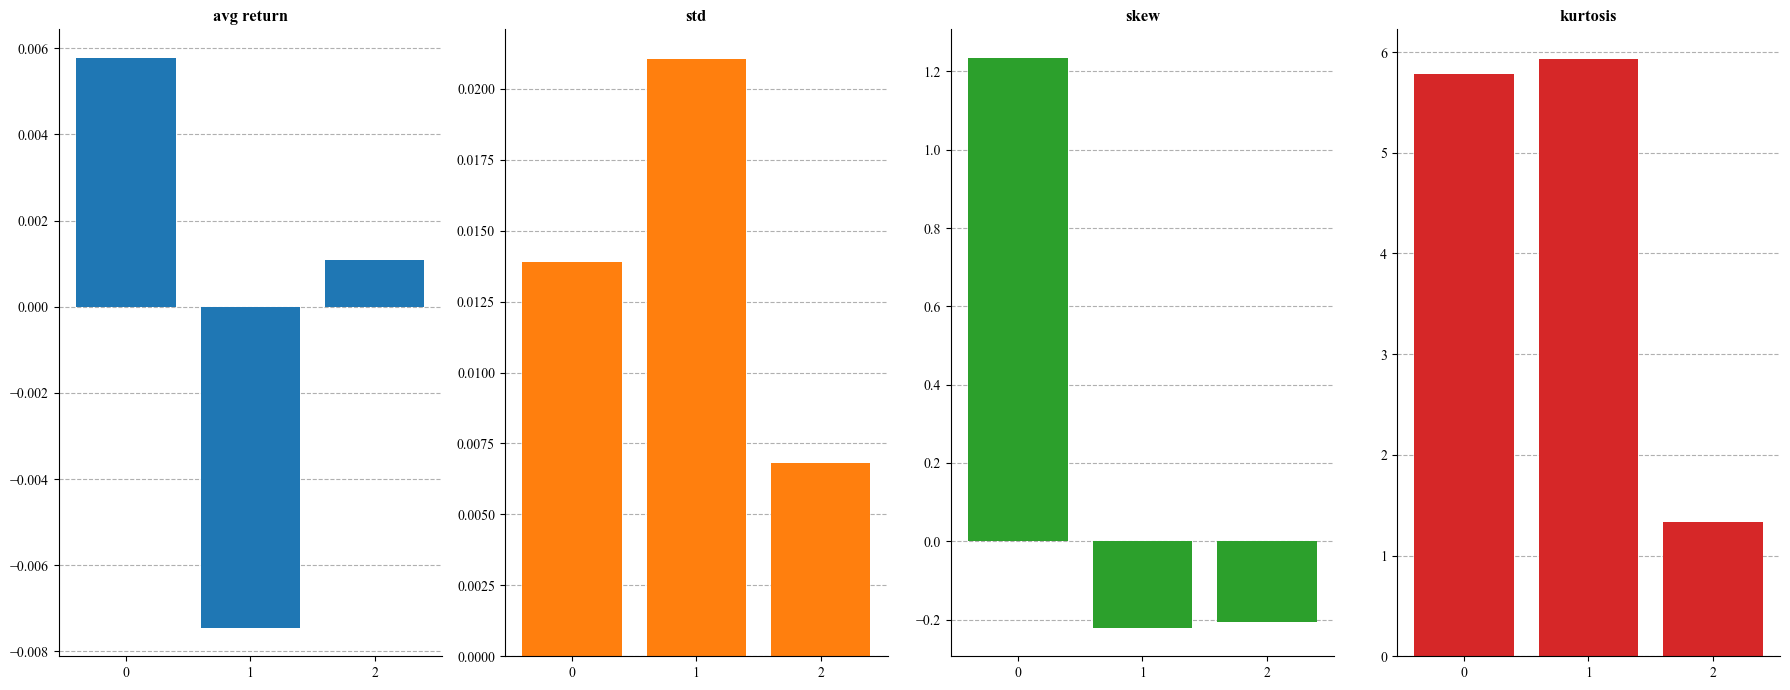

In [24]:
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728']

fig, ax = plt.subplots(1, len(groups_performance.columns), figsize=(18,7))
for i, col in enumerate(groups_performance.columns):
    ax[i].bar(groups_performance.index, groups_performance[col], color=colors[i], zorder=2)
    ax[i].set_xticks([0, 1, 2])
    ax[i].set_title(col, weight='bold')
    ax[i].grid(ls='--', axis='y', zorder=0)
sns.despine()
plt.tight_layout()
plt.show()

🔍 An additional layer for understanding the statistical behavior of the clusters—and comparing them—can be obtained by visualizing the **density functions of the log returns**.

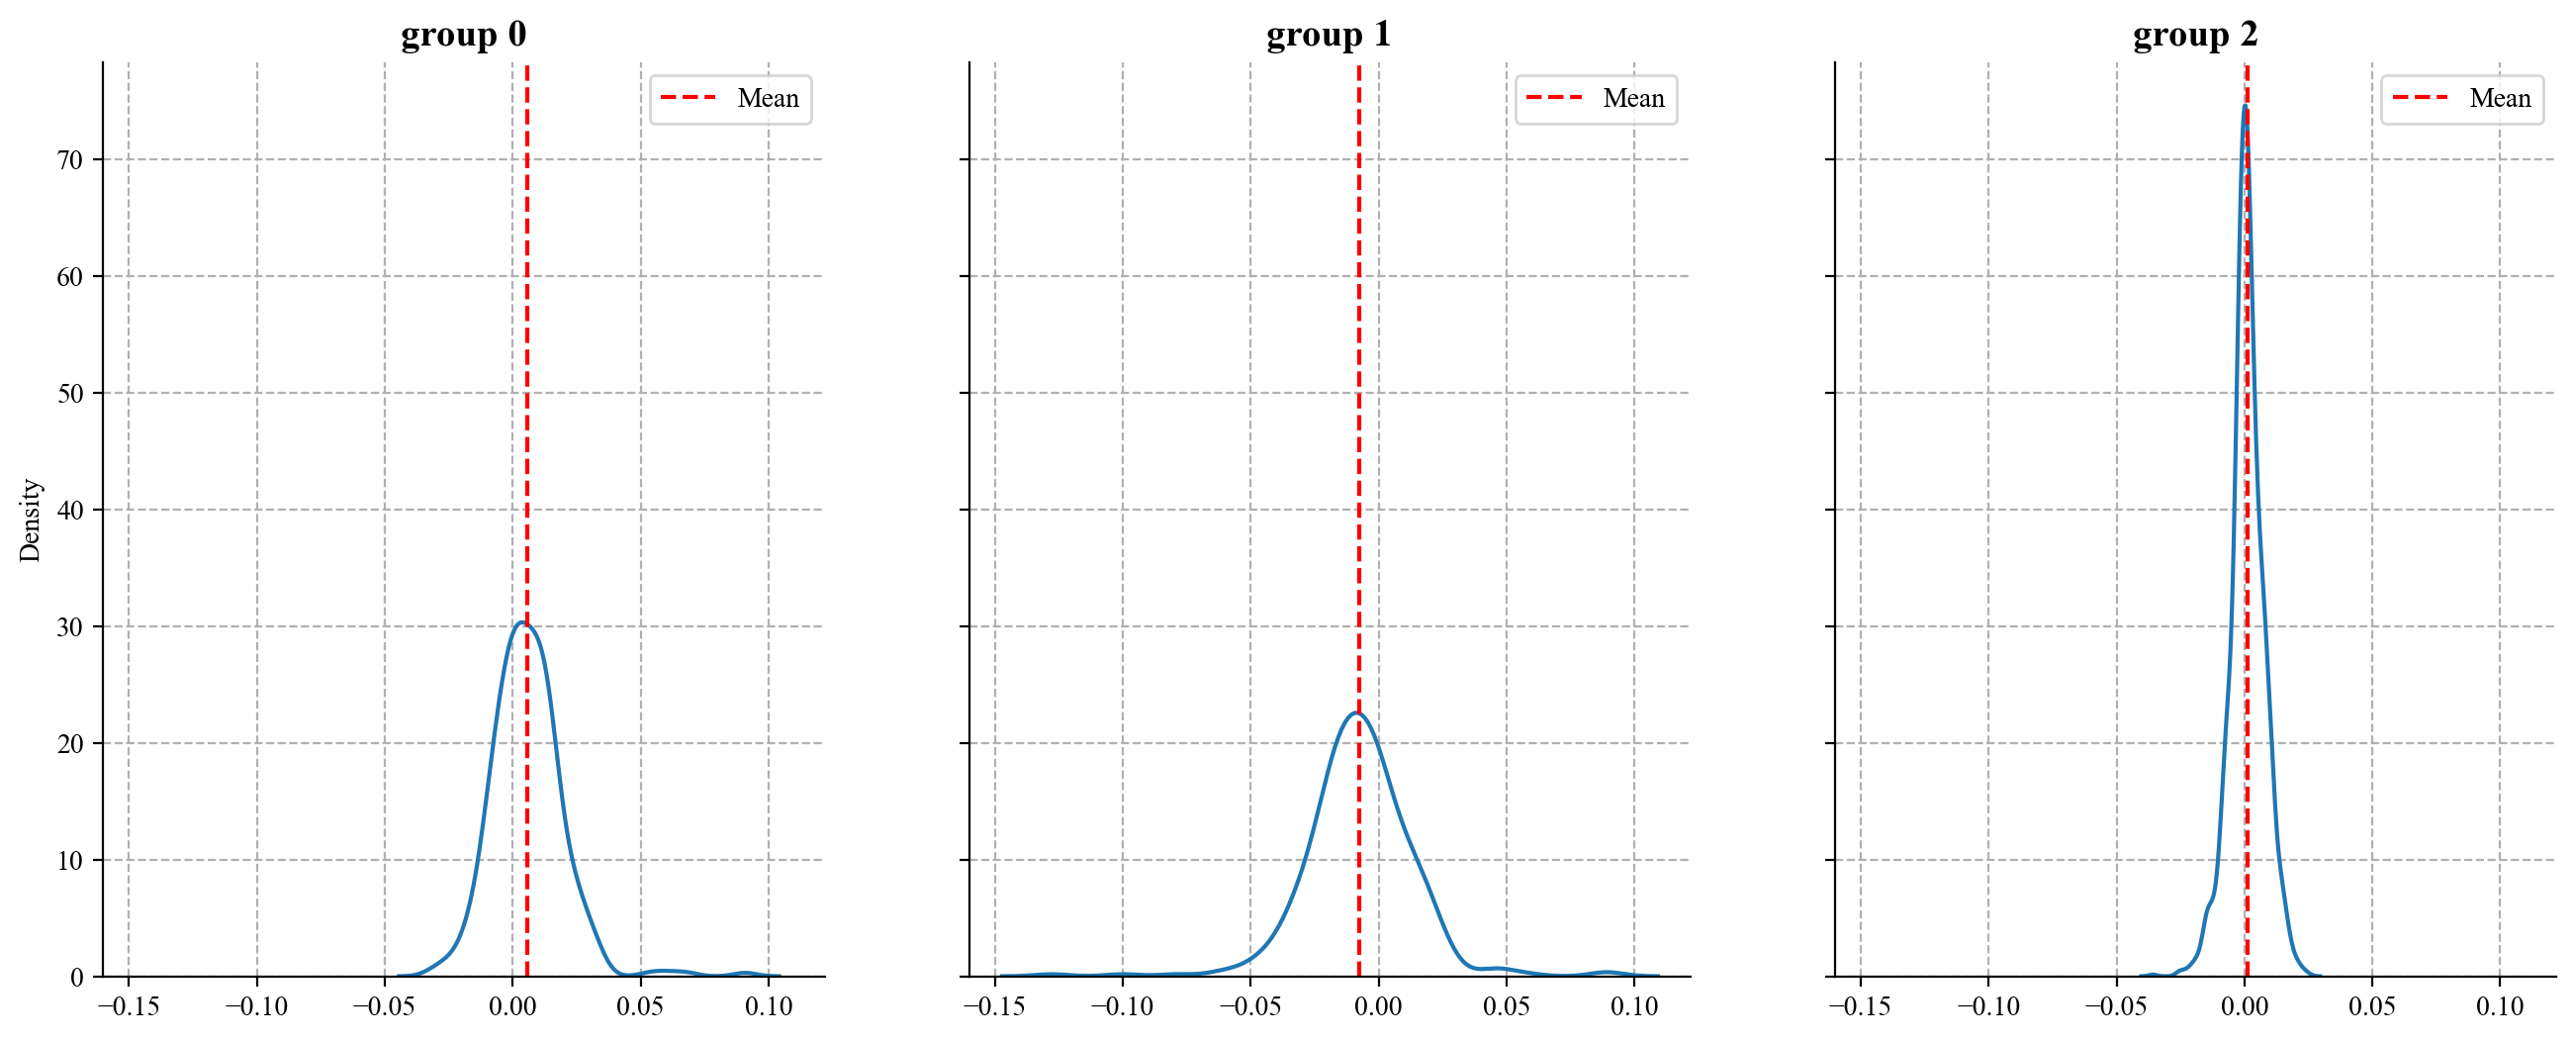

In [25]:
fig, ax = plt.subplots(1,len(groups), figsize=(16,6), dpi=200, sharex=True, sharey=True)

for i, (group_name, group) in enumerate(groups):
    sns.kdeplot(group['^GSPC'], ax=ax[i])
    ax[i].axvline(group['^GSPC'].mean(), color='r', ls='--', label='Mean')
    ax[i].set_title(f'group {group_name}', size=14, weight='bold')
    ax[i].grid(ls='--')
    ax[i].set_xlabel(None)
    ax[i].legend()

sns.despine()
plt.show()

In [26]:
def make_statistics(groupby_object):
    for name, group in groupby_object:
        data = group['^GSPC']
        print(f'🔵 GROUP {name}')
        print(f'Mean: {np.mean(data)}')
        print(f'Std: {np.std(data)}')
        print(f'Skew: {st.skew(data)}')
        print(f'Kurtosis: {st.kurtosis(data)}')
        print('-'*30)

make_statistics(groups)

🔵 GROUP 0
Mean: 0.005777313139119269
Std: 0.013862024331224214
Skew: 1.2346455760817934
Kurtosis: 5.7772352491447805
------------------------------
🔵 GROUP 1
Mean: -0.007449828854945605
Std: 0.021013568552200015
Skew: -0.22092738819088678
Kurtosis: 5.928637630532602
------------------------------
🔵 GROUP 2
Mean: 0.001086628221569705
Std: 0.006806078705491892
Skew: -0.20500739532539514
Kurtosis: 1.3372578087325886
------------------------------


## 5.2. Market-Level Interpretation of Clusters

After analyzing the statistical behavior of the clusters, we now shift to a **market-oriented perspective**.

To do this, we visualize the **log returns** over time, colored by cluster assignment.  
Alongside this, we plot the **S&P 500 index** and the **VIX index** to explore potential relationships between cluster occurrences and market dynamics or sentiment.

This joint visualization helps us characterize how different regimes align with overall market trends and volatility expectations.



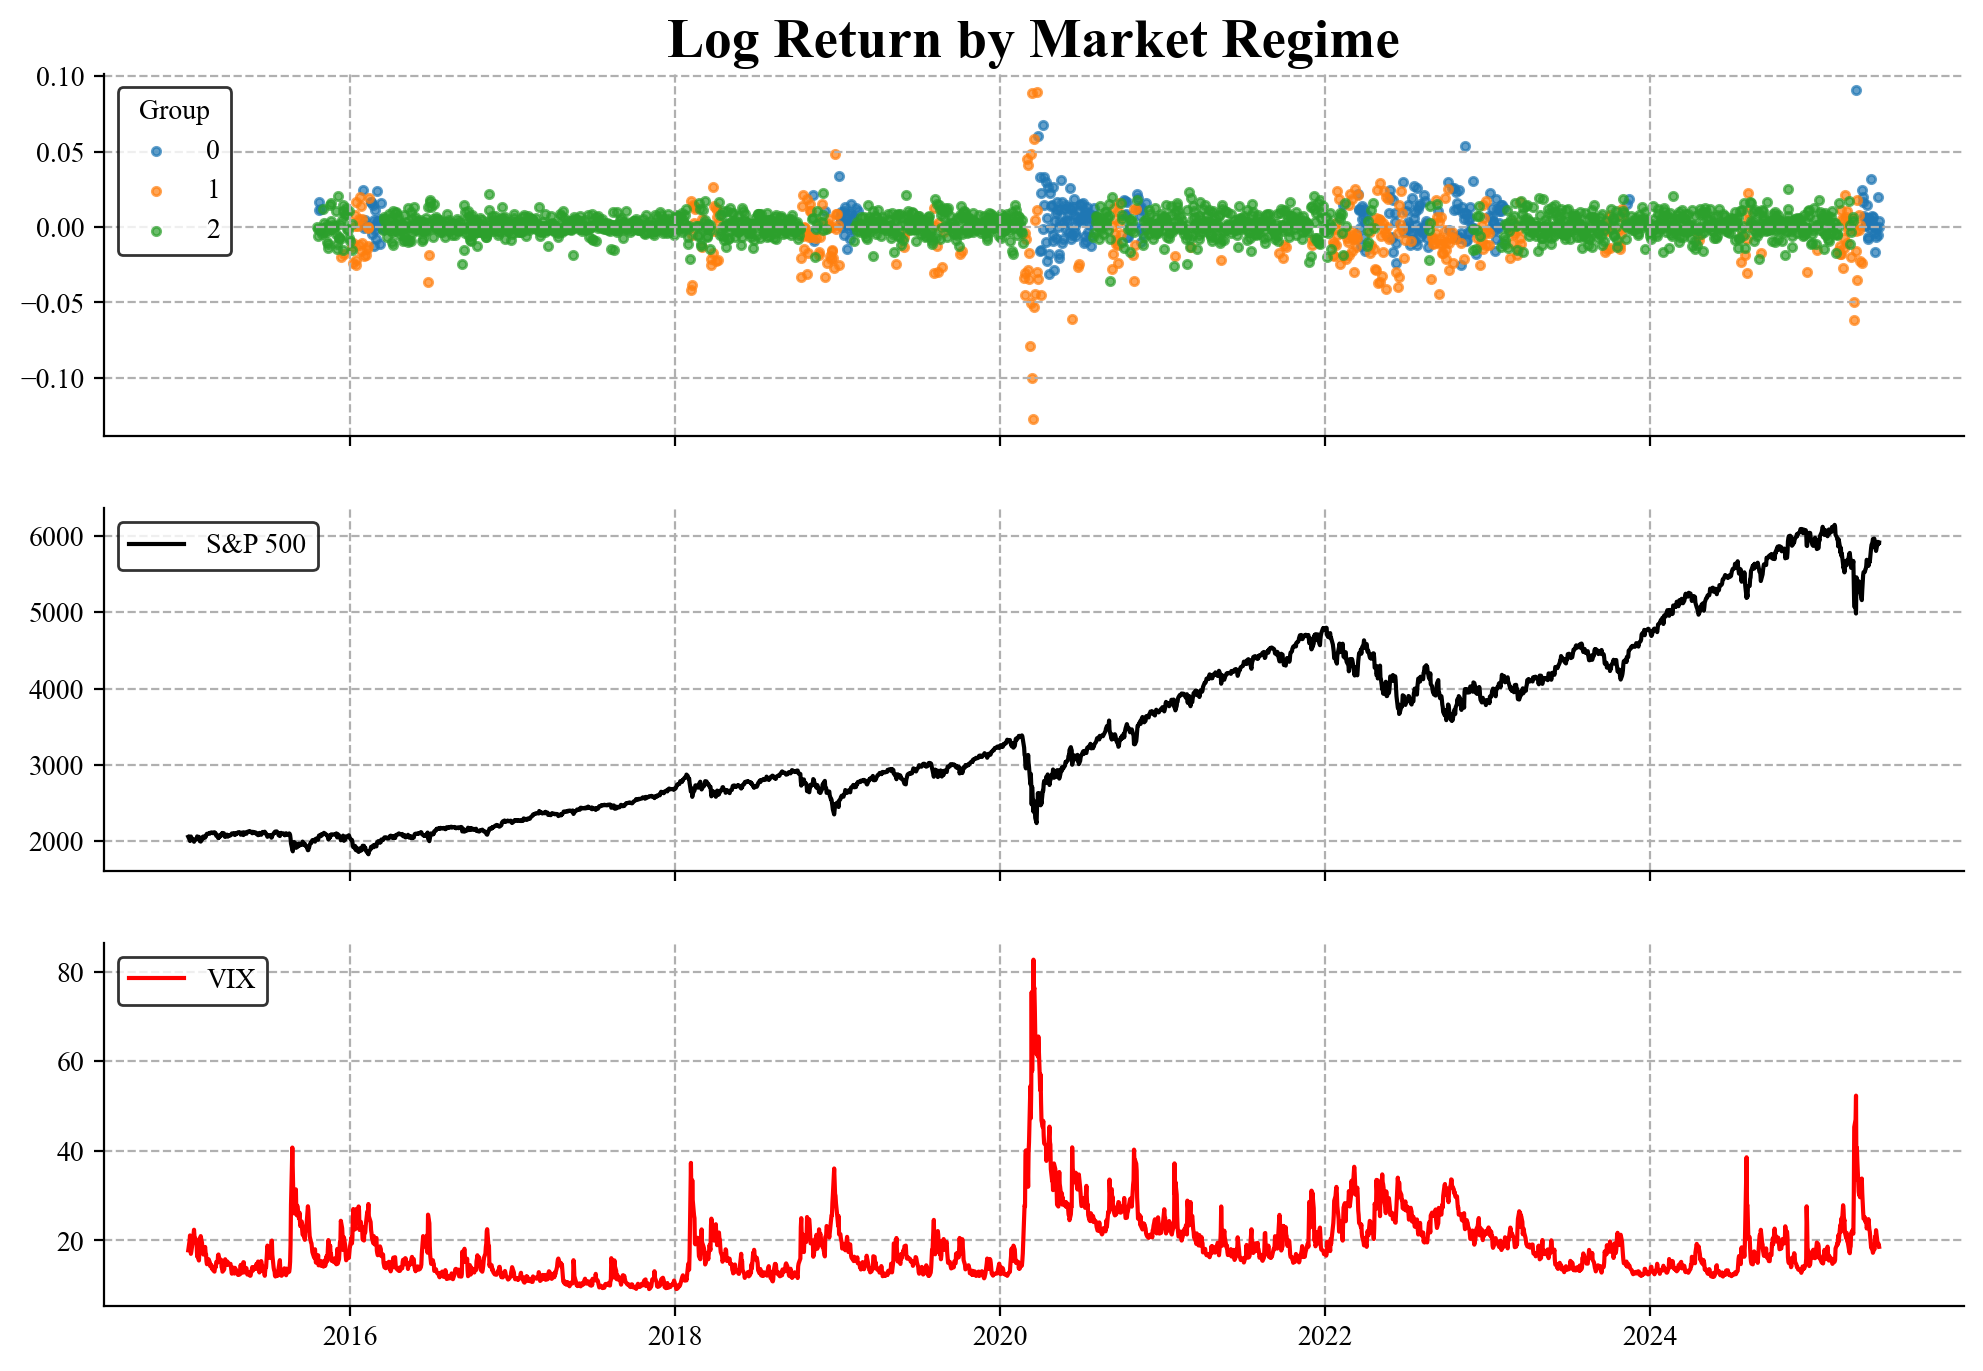

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(12,8), dpi=200, sharex=True)

for group_name, group in groups:
    ax[0].scatter(group.index, group['^GSPC'], s=9, alpha=.7, label=group_name)
ax[0].set_title('Log Return by Market Regime', size=20, weight='bold')
ax[0].grid(ls='--')
ax[0].legend(title='Group', edgecolor='k')

ax[1].plot(close, color='k', label='S&P 500')
ax[1].grid(ls='--')
ax[1].legend(edgecolor='k')

ax[2].plot(vix_close, color='r', label='VIX')
ax[2].grid(ls='--')
ax[2].legend(edgecolor='k', loc='upper left')

sns.despine()
plt.show()

🔍 We now ask the following question:  
**What would happen if, over a full decade, we entered the market only on days corresponding to a specific regime?**

A cumulative return plot of this type provides an additional perspective on how market regimes interact and complement each other,  
as well as insights into their internal behavior over time.


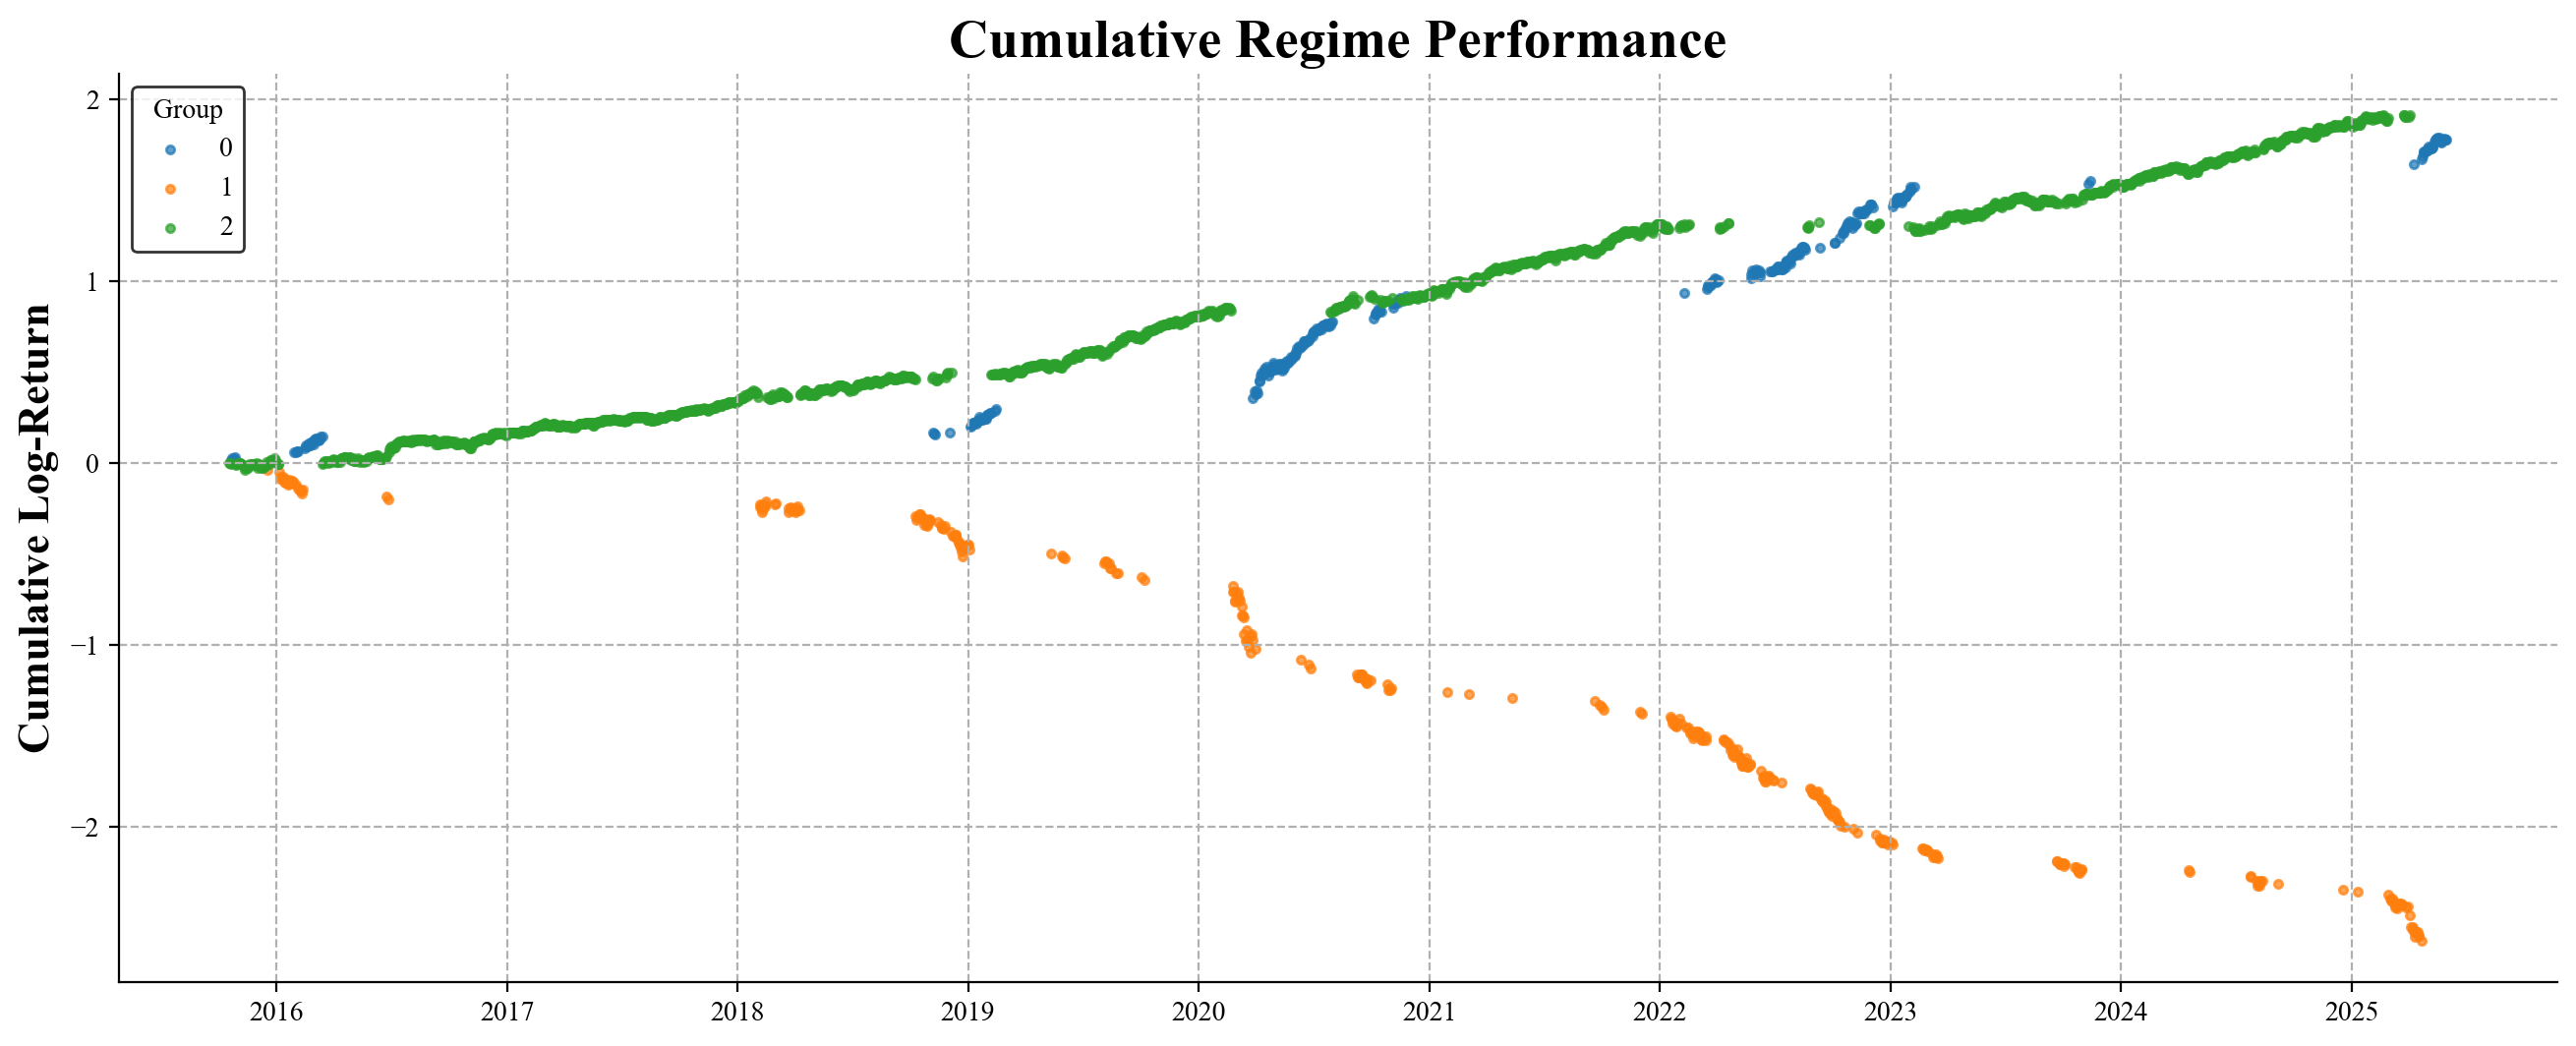

In [28]:
plt.figure(figsize=(16,6), dpi=200)
for group_name, group in groups:
    plt.scatter(group.index, group['^GSPC'].cumsum(), alpha=.7, s=9, label=group_name)

plt.ylabel('Cumulative Log-Return', size=16, weight='bold')
plt.title('Cumulative Regime Performance', size=20, weight='bold')
plt.grid(ls='--')
plt.legend(title='Group', edgecolor='k')
sns.despine()
plt.show()

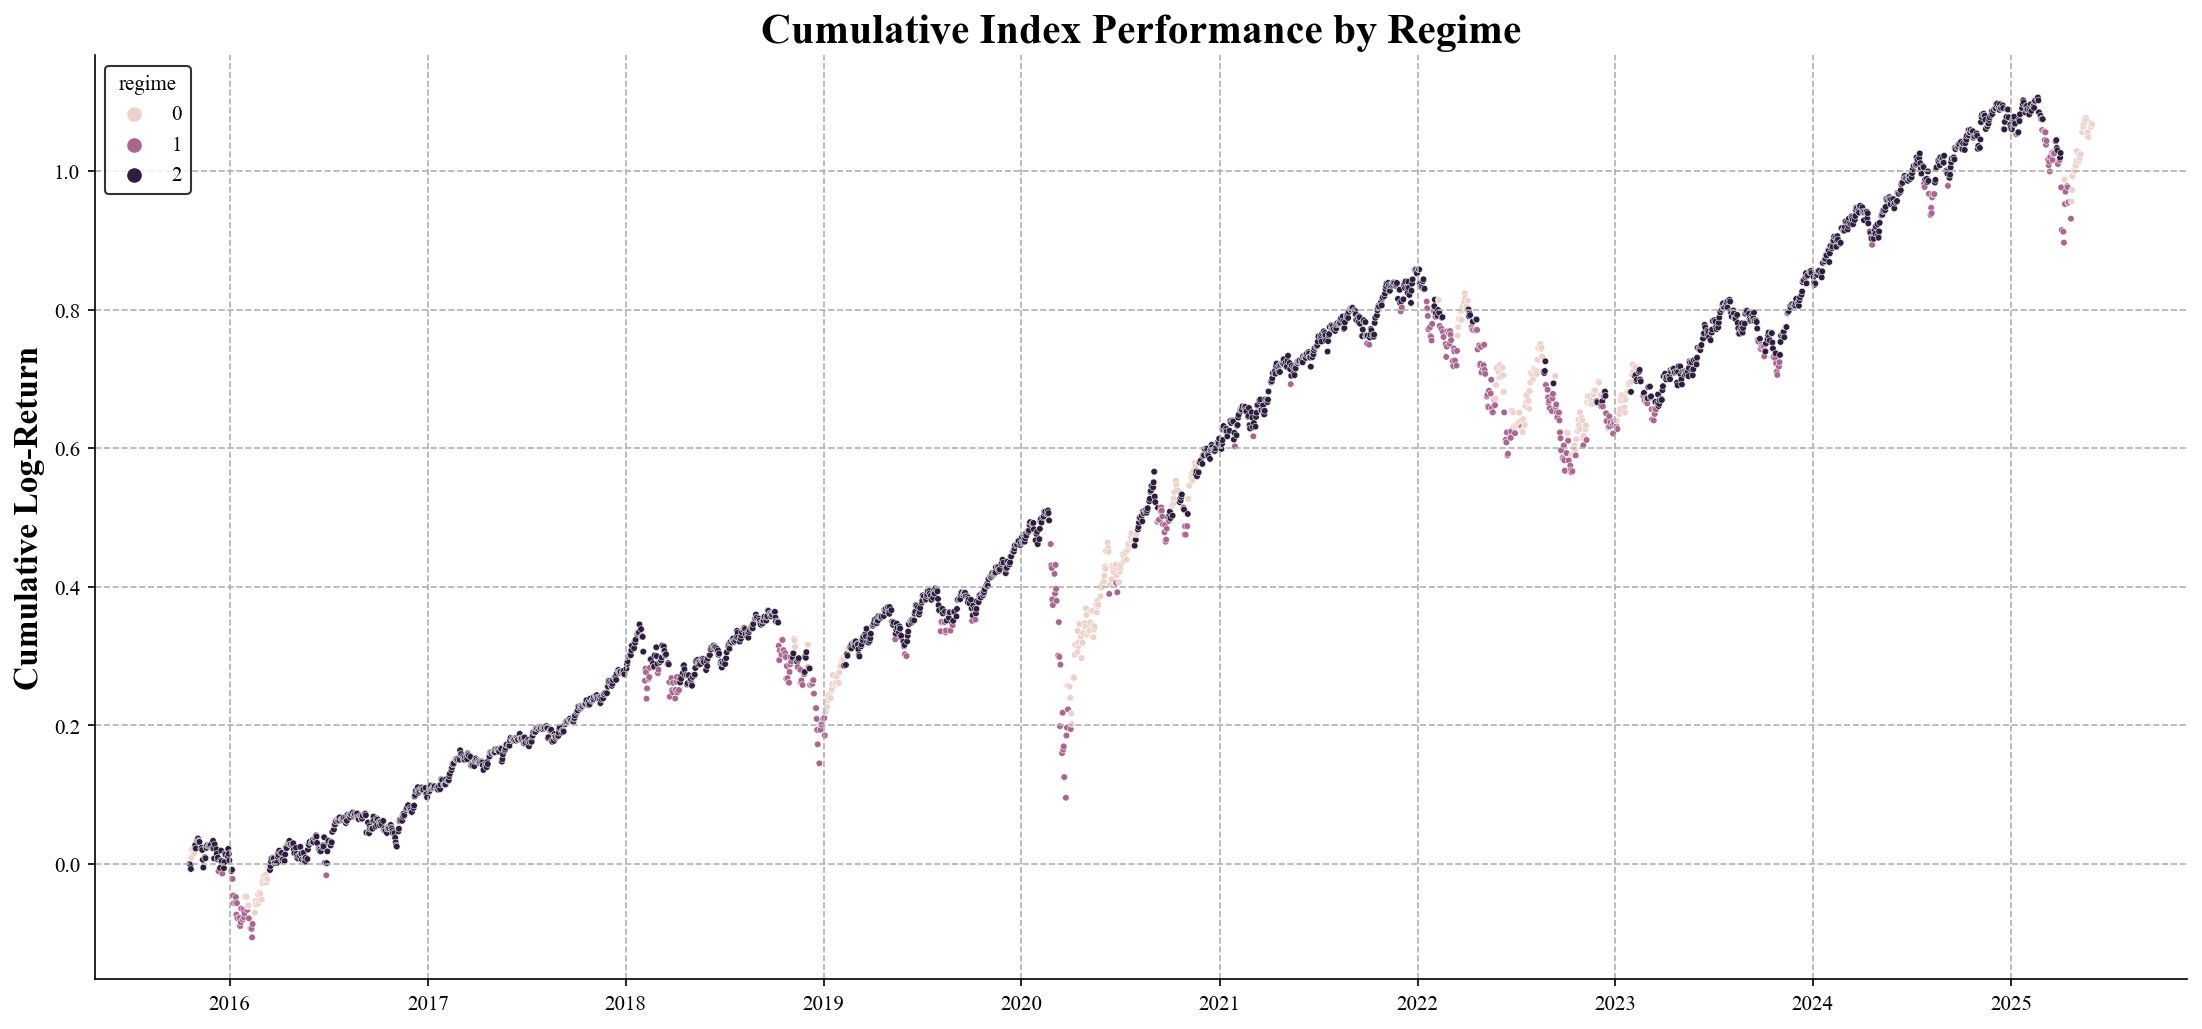

In [29]:
plt.figure(figsize=(18,8), dpi=150)
sns.scatterplot(data=regimes_df,
                x = regimes_df['^GSPC'].index, 
                y = regimes_df['^GSPC'].cumsum(),
                hue=regimes_df['cluster'], s=10)

plt.ylabel('Cumulative Log-Return', size=16, weight='bold')
plt.xlabel(None)
plt.title('Cumulative Index Performance by Regime', size=20, weight='bold')
plt.grid(ls='--')
plt.legend(title='regime', edgecolor='k')
sns.despine()
plt.show()

# 📊 6. Advanced Statistics
After gaining a basic understanding of the behavior of the different market regimes,  
we can now proceed with more efficient statistical analysis and comparisons between the groups.

At this stage, we apply several statistical tests:

- **Shapiro-Wilk test** – to assess the normality of each distribution  
- **Independent t-test** – to compare the means of two groups  
- **Levene's test** – to compare variances between groups

These tests provide a relatively robust statistical basis for evaluating the **similarities and differences** across clusters.  
In general, we aim to observe **low statistical similarity** between clusters, which would strengthen the validity of the overall classification.


In [30]:
def check_normality(groupby_object, confidence_level=0.05):
    print(f'Confience Level: {confidence_level}')
    for name, group in groupby_object:
        results = st.shapiro(group['^GSPC'])
        pvalue = results[1]
        if pvalue < confidence_level:
            print(f'❌ group {name} is not Normally Distributed. pvalue={round(pvalue, 4)}')
        else:
            print(f'✅ group {name} is Normally Distrivuted. pvalue={round(pvalue, 4)}')

check_normality(groups)

Confience Level: 0.05
❌ group 0 is not Normally Distributed. pvalue=0.0
❌ group 1 is not Normally Distributed. pvalue=0.0
❌ group 2 is not Normally Distributed. pvalue=0.0


In [31]:
def compare_means(groupby_object, confidence_level=0.05):
    print(f'Confience Level: {confidence_level}')
    for (name1, group1), (name2, group2) in combinations(groupby_object, 2):
        results = st.ttest_ind(group1['^GSPC'], group2['^GSPC'])
        pvalue = results[1]
        if pvalue<confidence_level:
            print(f'❌ groups {name1}, {name2} DONT have  the same mean. pvalue={round(pvalue, 4)}')
        else:
            print(f'✅ grousp {name1}, {name2} HAVE the same mean. pvalue={round(pvalue, 4)}')

compare_means(groups)

Confience Level: 0.05
❌ groups 0, 1 DONT have  the same mean. pvalue=0.0
❌ groups 0, 2 DONT have  the same mean. pvalue=0.0
❌ groups 1, 2 DONT have  the same mean. pvalue=0.0


In [32]:
def compare_variance(groupby_object, confidence_level=0.05):
    print(f'Confidence Level: {confidence_level}')
    for (name1, group1), (name2, group2) in combinations(groupby_object, 2):
        results = st.levene(group1['^GSPC'], group2['^GSPC'])
        pvalue = results[1]
        if pvalue < 0.05:
            print(f'❌ groups {name1}, {name2} DONT have the same variance. pvalue={round(pvalue, 4)}')
        else:
            print(f'✅ groups {name1}, {name2} HAVE the same variance. pvalue={round(pvalue, 4)}')

compare_variance(groups)

Confidence Level: 0.05
❌ groups 0, 1 DONT have the same variance. pvalue=0.0
❌ groups 0, 2 DONT have the same variance. pvalue=0.0
❌ groups 1, 2 DONT have the same variance. pvalue=0.0


# 🧬 7. Principal Component Analysis (PCA)

At this stage, we perform **Principal Component Analysis** to gain further insight into how the clusters are separated and on what basis.

As in the previous analysis, we aim to observe the following:

1. **High between-cluster variance** – Clear separation between groups increases confidence in the quality of the clustering.

2. **High within-cluster compactness** – Tight grouping of points within each cluster indicates consistent internal behavior and strengthens the interpretability of the classification.


In [33]:
pca = PCA(n_components=2, 
         random_state=999)

In [34]:
pca_df = scaled_features_df

In [35]:
principal_components = pca.fit_transform(pca_df)

In [36]:
explained_variance_ratio = sum(pca.explained_variance_ratio_)
print(f'PCA(2) Explained Variance Ratio: {explained_variance_ratio}')

PCA(2) Explained Variance Ratio: 0.5147678750372113


In [37]:
pca_components_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_components_df['cluster'] = regimes_df['cluster'].values

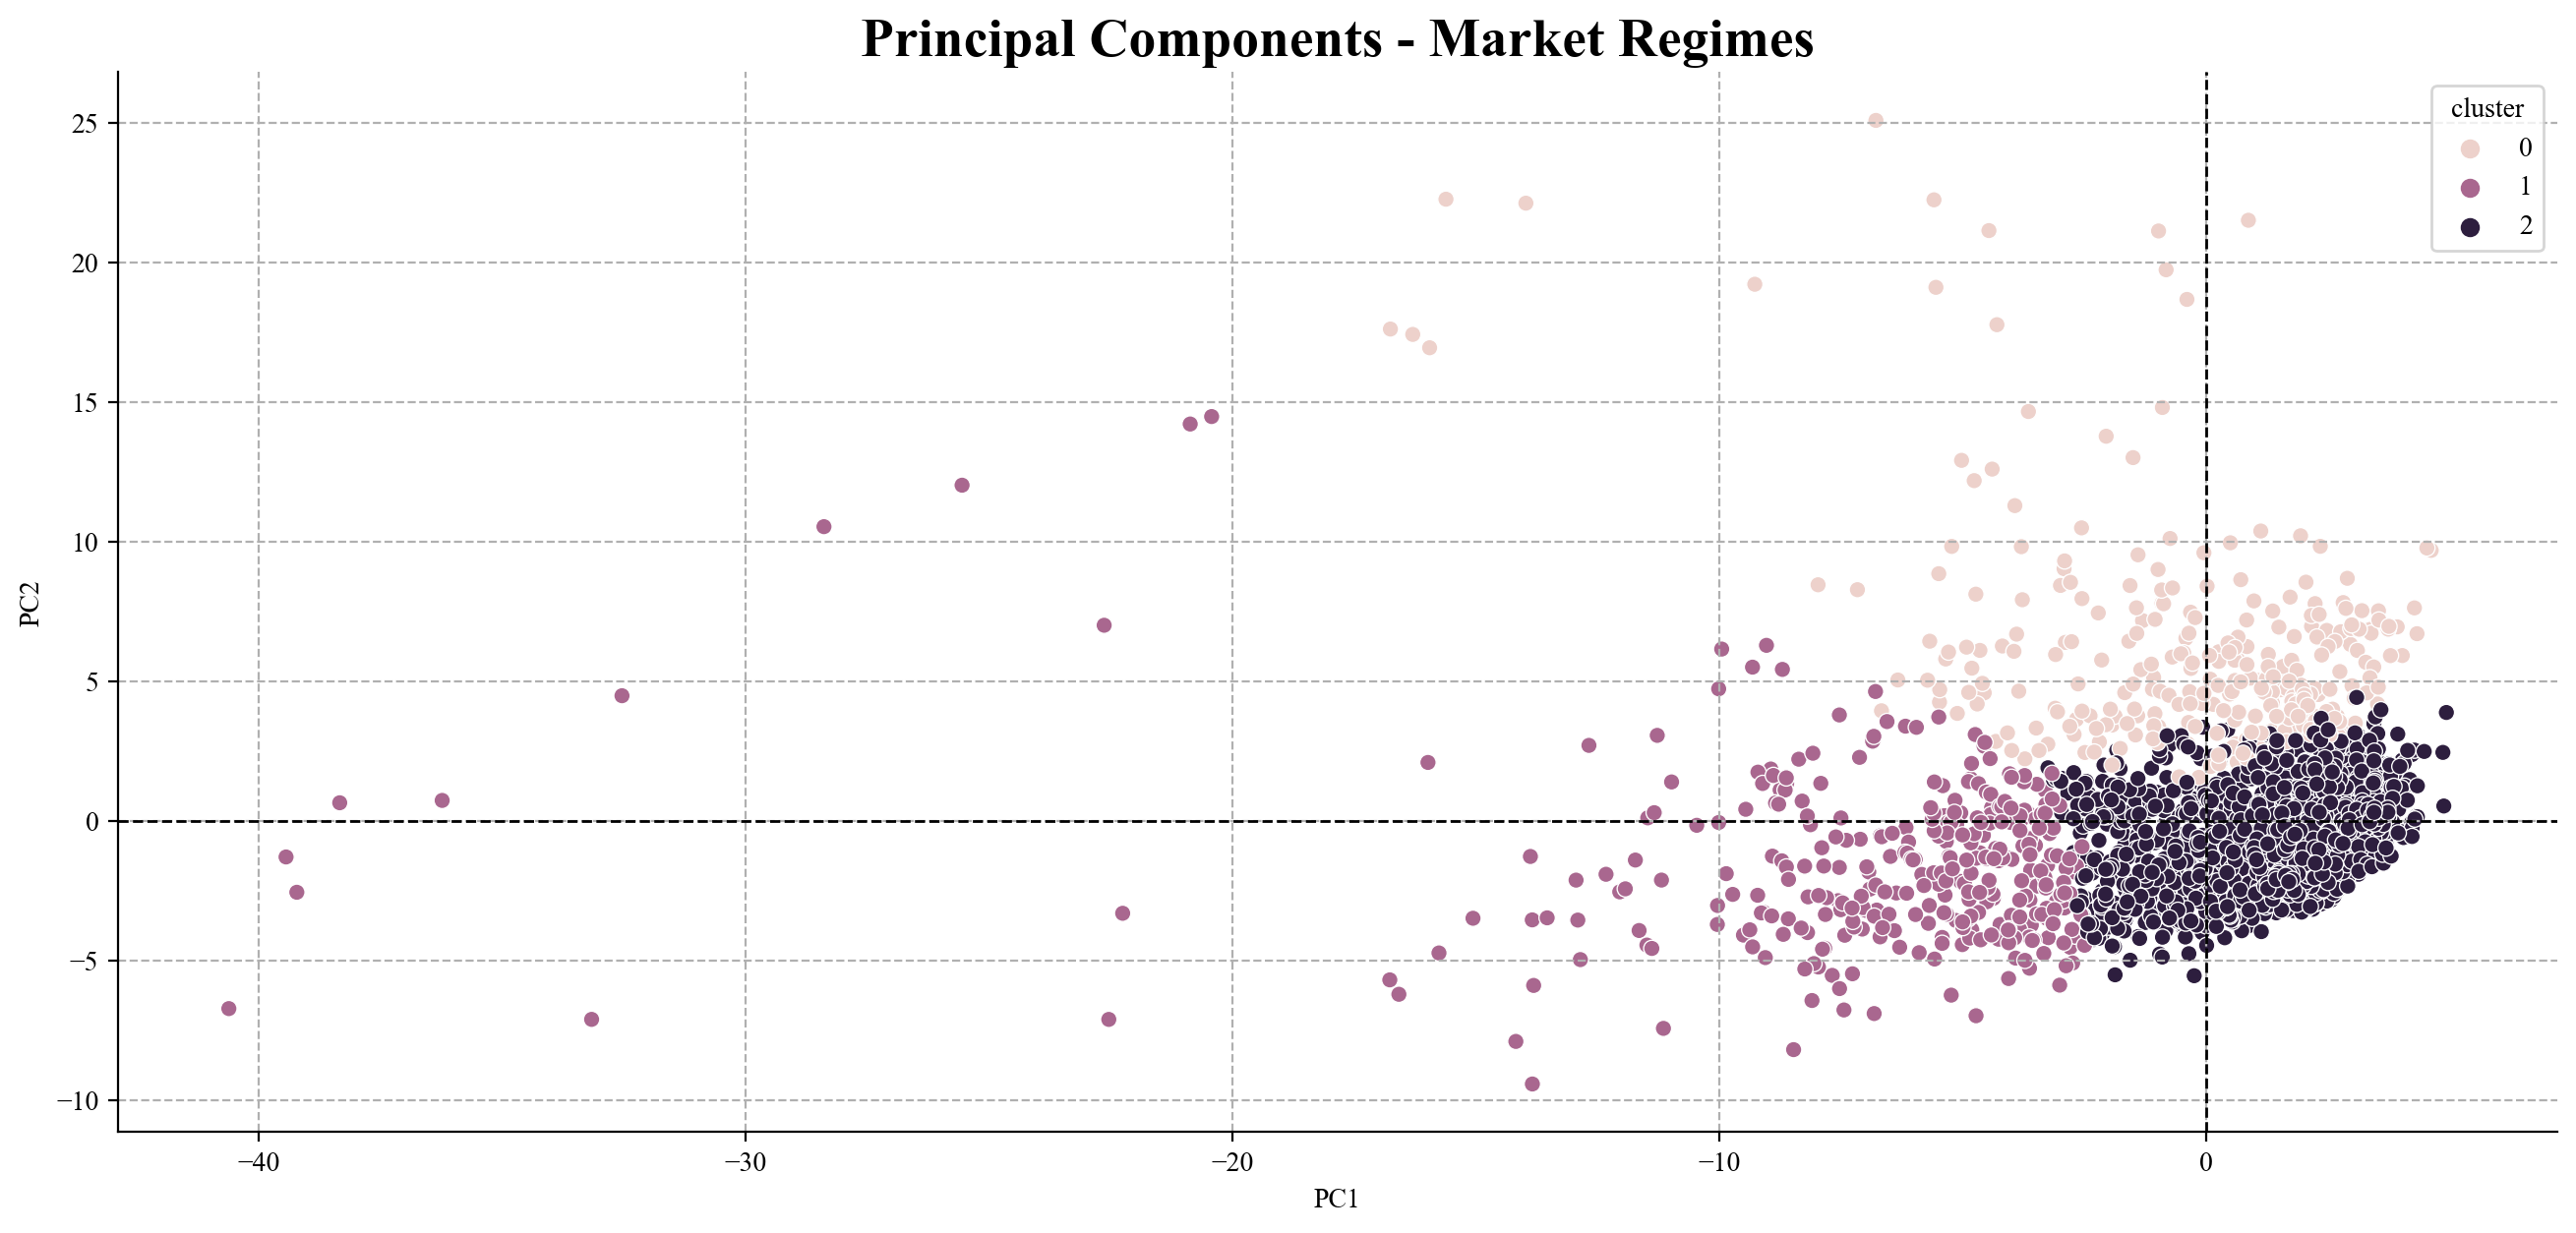

In [38]:
plt.figure(figsize=(16,7), dpi=200)
sns.scatterplot(pca_components_df, x='PC1', y='PC2', hue='cluster')
plt.axvline(ls='--', color='k', lw=1)
plt.axhline(ls='--', color='k', lw=1)

plt.title('Principal Components - Market Regimes', size=20, weight='bold')
plt.grid(ls='--')
sns.despine()
plt.show()

In [39]:
pca_groups = pca_components_df.groupby('cluster')
pca_groups.agg(['mean', 'median', 'std'])

PC1                           PC2                    
             mean    median       std      mean    median       std
cluster                                                            
0       -0.359683  0.478115  3.324696  6.106762  4.948448  3.961106
1       -7.090642 -5.414004  5.678832 -1.589105 -1.888827  3.025283
2        1.482758  1.891300  1.624110 -0.751717 -0.858136  1.605202

🔍 The first two principal components preserve just over **50% of the original variance** in the data.  
Despite this moderate retention, they are sufficient to reveal a clear and highly effective separation between the clusters.

**Cluster 2**, which so far reflects a **calm bear market regime**, appears tightly grouped along both components.  
In contrast, **Clusters 0 and 1**, which exhibit more "volatile" statistical characteristics, display **greater dispersion** across the component space.

## 7.1 Interpreting Principal Components Through Feature Loadings

At this stage, we aim to deepen our understanding of the principal components by examining the **feature loadings**—that is, the contribution of each original feature to the components' construction.

By analyzing these loadings, we can identify which features are most influential in shaping the variance captured by each component.  
This, in turn, helps us interpret the separation between clusters in terms of the original feature space, and understand **which attributes drive the differences between market regimes**.


In [40]:
components = pca.components_
loadings = pd.DataFrame({'ticker': pca_df.columns,
                        'PC1': components[0],
                        'PC2': components[1]}
                       )

pc1 = loadings.drop(columns='PC2').set_index('ticker').sort_values(by='PC1')
pc2 = loadings.drop(columns='PC1').set_index('ticker').sort_values(by='PC2')

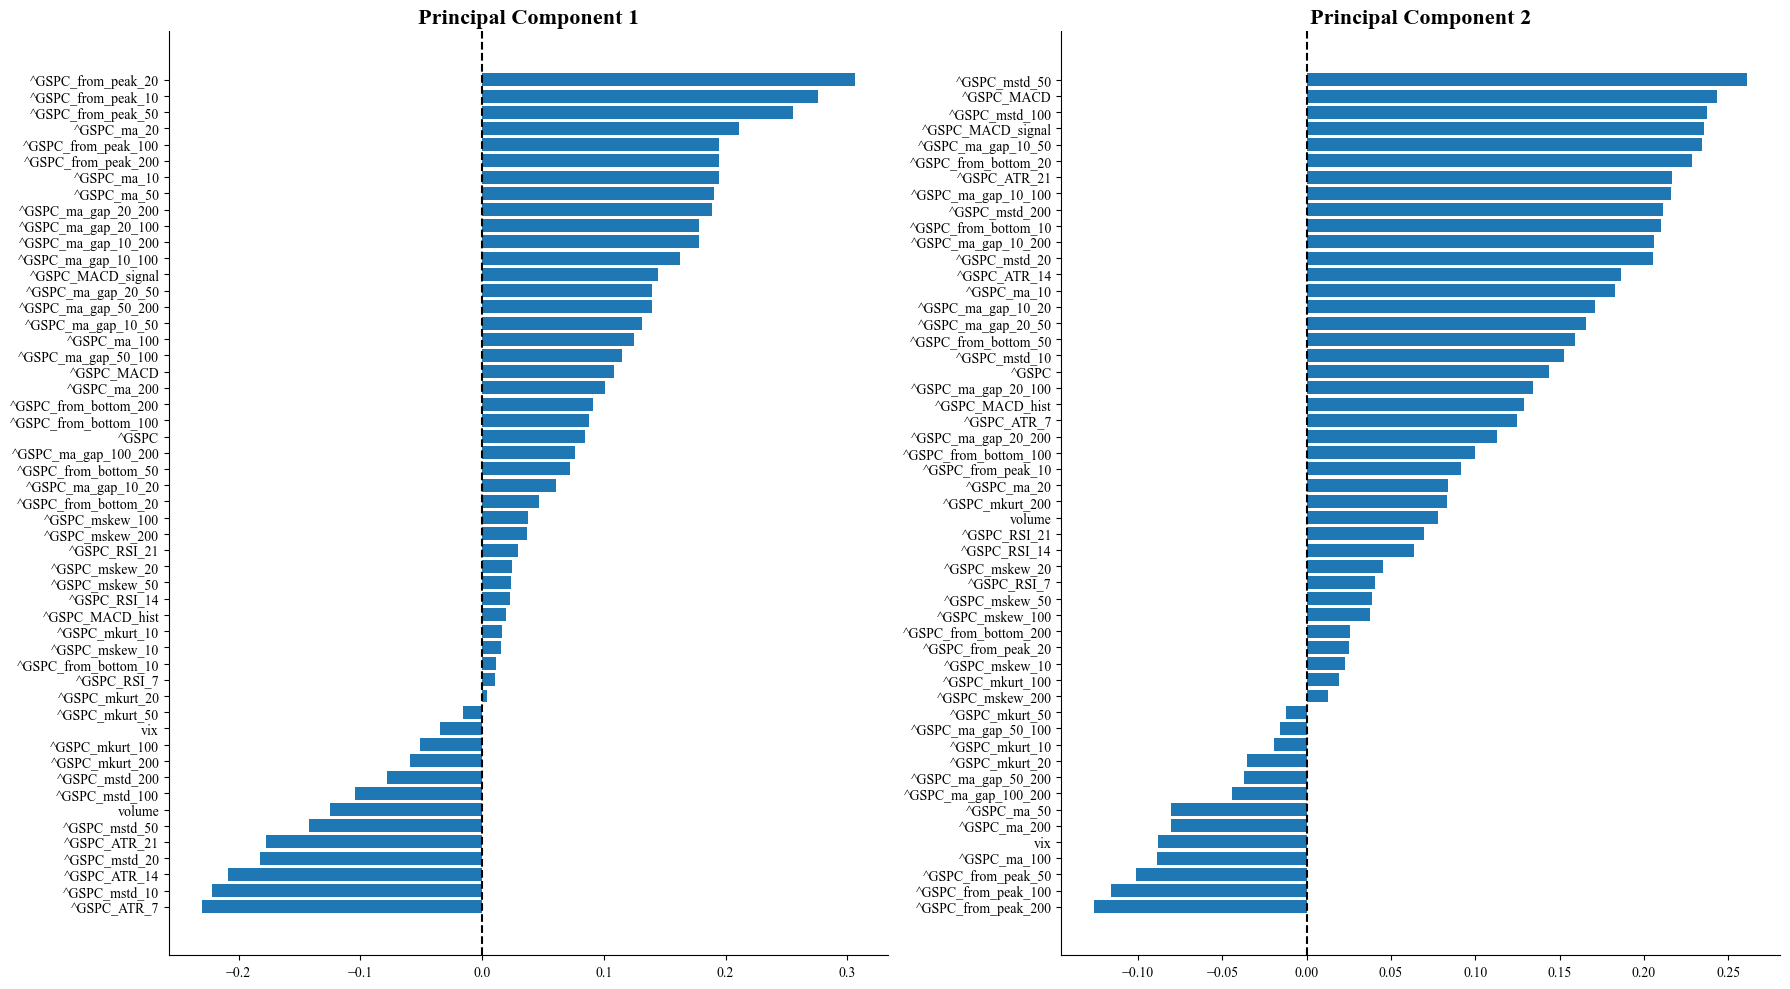

In [41]:
fig, ax = plt.subplots(1,2, figsize=(18,10))
ax[0].barh(pc1.index, pc1.values.reshape(-1))
ax[0].axvline(0, ls='--', color='k')
ax[0].set_title('Principal Component 1', size=16, weight='bold')

ax[1].barh(pc2.index, pc2.values.reshape(-1))
ax[1].axvline(0, ls='--', color='k')
ax[1].set_title('Principal Component 2',  size=16, weight='bold')

plt.tight_layout()
sns.despine()
plt.show()

### 1️⃣ Interpretation of Principal Component 1

Principal Component 1 appears to be driven primarily by **trend-related features**,  
such as **distance from peaks**, **moving averages**, and **moving average gaps**—all of which have strong positive loadings.  
On the other hand, **stress-related indicators** such as high standard deviation and low ATR contribute negatively to this component.

This aligns well with the statistical behavior observed in the clusters:

- **Cluster 2**, representing a **calm bullish regime**, shows a **high average PC1 score (~+1.48)** with **low dispersion (~1.62)**,  
  reflecting stability and low sensitivity to trend volatility.

- **Cluster 1**, associated with a **volatile bearish regime**, has a **strongly negative mean PC1 value (~−7.09)** and **high spread (~5.67)**,  
  consistent with extreme movements and susceptibility to tail-risk environments.

- **Cluster 0**, representing a **strong bullish trend**, has an **almost neutral mean along PC1 (~−0.36)** with **moderate dispersion (~3.32)**.  
  This suggests mixed sensitivity to trend-following features, possibly due to internal variability or alternating micro-regimes.

Altogether, PC1 serves as a useful axis to separate stable uptrends from turbulent downturns, and highlights the underlying market dynamics of each regime.

### 2️⃣ Interpretation of Principal Component 2

Principal Component 2 is influenced by a combination of **volatility measures** and **short-to-medium term momentum features**.  
Positive loadings are dominated by **standard deviation (50–100 day)**, **MACD and MACD signal**, **short-term ATR**, and **distance from recent bottoms**,  
indicating increased short-term activity, potential recovery, or post-selloff bounce behavior.

Conversely, negative loadings are associated with **long-term distance from peaks**, **low momentum (MACD histogram)**, and **high kurtosis**,  
suggesting prolonged weakness, technical deterioration, or fat-tailed risk exposure.

This axis appears to distinguish between:

- **Short-term reactive volatility with signs of recovery** (high PC2 values), and  
- **Extended drawdowns or structurally weak markets** (low PC2 values).

While less interpretable than PC1, PC2 offers an orthogonal perspective on regime behavior—highlighting whether market movements are more likely  
to be driven by **short-term technical signals and reversals**, or by **longer-term drawdowns and systemic stress**.

# 🔬 Interpreting Market Regimes

Based on the PCA projections, statistical summaries, feature loadings, and cumulative performance plots, we can assign qualitative interpretations to the three identified market regimes:

- **Cluster 0 – Strong Bull Market Regime**  
  This regime is characterized by consistently **high positive returns**, **moderate volatility**, and strong **positive skewness**, indicating periods of upward momentum and favorable price trends.  
  It aligns with prolonged rallies in the S&P 500.

- **Cluster 1 – Volatile Bear Market Regime**  
  This group shows **strongly negative returns**, **very high volatility**, and **fat-tailed distributions** (high kurtosis), pointing to chaotic and risk-intensive environments.  
  It correlates with periods of sharp declines, spikes in VIX, and market distress.

- **Cluster 2 – Stable Bull Market Regime**  
  This regime exhibits **low volatility**, **minimal dispersion** in PCA space, and **slightly positive average returns**, suggesting a stable but stagnant environment.  
  It likely reflects periods of consolidation, post-selloff stabilization, or low-participation markets.

Notably, from the market-level analysis, **Cluster 0 also frequently appears as a transitional regime** between stress periods (Cluster 1) and calmer phases (Cluster 2).  
Its strongly positive statistical profile suggests that it may represent **periods of upward correction**, where the market recovers from oversold conditions and begins to regain bullish momentum.

Together, these clusters capture distinct market conditions that differ in both statistical and structural behavior.  
This differentiation provides a solid foundation for further analysis, including regime-aware modeling, risk assessment, and strategy design.